## Описание задачи

В данном соревновании участникам предлагается решить задачу предсказания следующего заказа пользователя (безотносительно конкретного момента времени, когда этот заказ произойдет). Заказ пользователя состоит из списка уникальных категорий товаров, вне зависимости от того, сколько продуктов каждой категории он взял.

## Описание данных

В качестве тренировочных данных представляется датасет с историей заказов 20000 пользователей вплоть до даты отсечки, которая разделяет тренировочные и тестовые данные по времени.

**train.csv:**

*    user_id - уникальный id пользователя
*    order_completed_at - дата заказа
*    cart - список уникальных категорий (category_id), из которых состоял заказ

В качестве прогноза необходимо для каждой пары пользователь-категория из примера сабмита вернуть 1, если категория будет присутствовать в следующем заказе пользователя, или 0 в ином случае. Список категорий для каждого пользователя примере сабмита - это все категории, которые он когда-либо заказывал.

**sample_submission.csv:**

Пример сабмита. В тест входят не все пользователи из тренировочных данных, так как некоторые из них так ничего и не заказали после даты отсечки.

*    id - идентификатор строки - состоит из user_id и category_id, разделенных точкой с запятой: f'{user_id};{category_id}'. Из-за особенностей проверяющей системы Kaggle InClass, использовать колонки user_id, category_id в качестве индекса отдельно невозможно
    target - 1 или 0 - будет ли данная категория присутствовать в следующем заказе пользователя


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from IPython.display import display

from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score , train_test_split
from sklearn.linear_model import LogisticRegression #LinearRegression
from sklearn.metrics import f1_score, confusion_matrix #make_scorer, 

import optuna

from lightgbm import LGBMClassifier #LGBMRegressor

from catboost import CatBoostClassifier #CatBoostRegressor

import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

In [3]:
def second_to_last_date(row):       
    '''
    получение даты предпоследнего заказа
    '''
    try:
        date_list = row['user_buy_date_list']
        date_list.sort
        second_to_last = date_list[-2]
        return second_to_last
    except:
        return np.NaN
    
def buy_num(row):
    '''
    возвращает номер покупки от последней к первой
    '''
    try:
        _date = row['order_completed_at']
        _list = row['user_buy_date_list']
        _list.sort(reverse=True)
        _num = _list.index(_date)
        return _num+1
    except:
        return 'error_value'

In [4]:
df = pd.read_csv('train.csv')
sample_sub = pd.read_csv('sample_submission.csv')

In [5]:
sample_sub

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0
...,...,...
790444,19998;26,0
790445,19998;31,0
790446,19998;29,1
790447,19998;798,1


In [6]:
display(df)
df['order_completed_at'] = df['order_completed_at'].astype('datetime64')
df.info()
print()
print('дубликатов:', df.duplicated().sum())
print()
print('кол-во уникальных покупателей:', df['user_id'].nunique())
print()
print('кол-во уникальных категорий:', df['cart'].nunique())

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157
...,...,...,...
3123059,12702,2020-09-03 23:45:45,441
3123060,12702,2020-09-03 23:45:45,92
3123061,12702,2020-09-03 23:45:45,431
3123062,12702,2020-09-03 23:45:45,24


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   user_id             int64         
 1   order_completed_at  datetime64[ns]
 2   cart                int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 71.5 MB

дубликатов: 0

кол-во уникальных покупателей: 20000

кол-во уникальных категорий: 881


## Анализ

### Даты

In [7]:
print('минимальная дата', df['order_completed_at'].min())
print('максимальная дата', df['order_completed_at'].max())

минимальная дата 2015-03-22 09:25:46
максимальная дата 2020-09-03 23:45:45


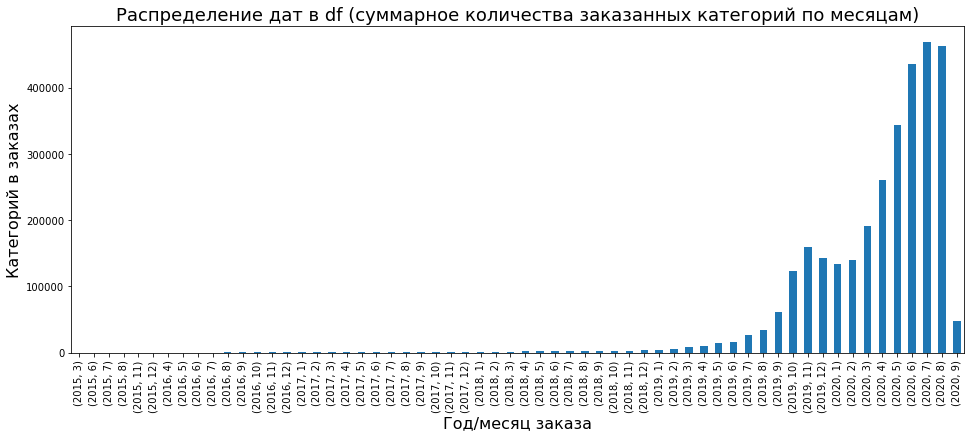

In [8]:
df['order_completed_at'].groupby([df['order_completed_at'].dt.year,
                                          df['order_completed_at'].dt.month]).count().plot(
    kind="bar", figsize=(16, 6))
plt.title('Распределение дат в df (суммарное количества заказанных категорий по месяцам)', fontsize=18) 
plt.ylabel('Категорий в заказах', fontsize=16)
plt.xlabel('Год/месяц заказа', fontsize=16);

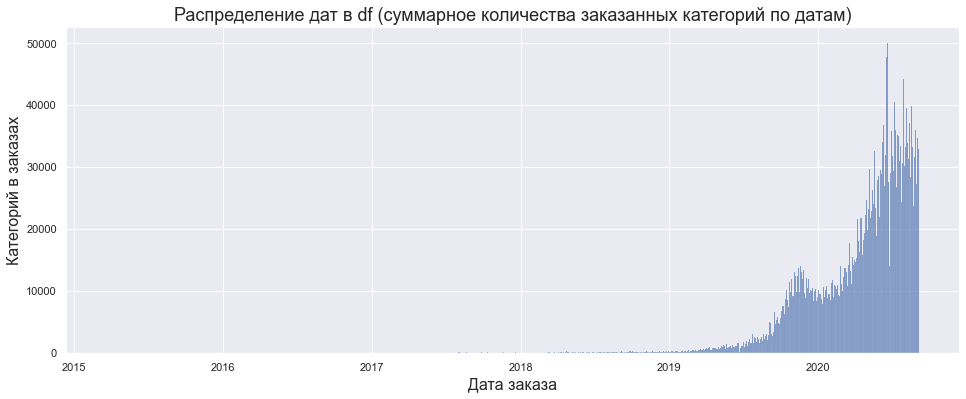

In [9]:
sns.set(rc={'figure.figsize':(16, 6)})

sns.histplot(df['order_completed_at'])
plt.title('Распределение дат в df (суммарное количества заказанных категорий по датам)', fontsize=18) 
plt.ylabel('Категорий в заказах', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16);

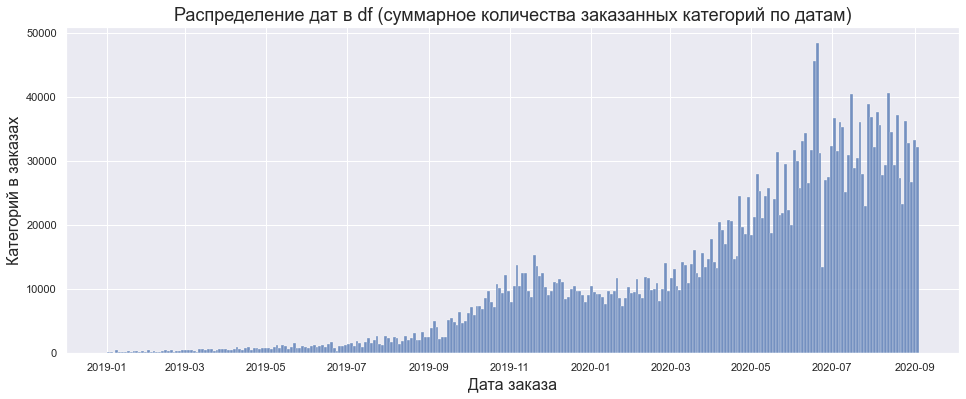

In [10]:
sns.histplot(df.query('order_completed_at > "2019"')['order_completed_at'])
plt.title('Распределение дат в df (суммарное количества заказанных категорий по датам)', fontsize=18) 
plt.ylabel('Категорий в заказах', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16);

#### Дата по покупателям

In [11]:
#дата первого/последнего заказа покупателя
first_last_user_date = df.pivot_table(index=['user_id'], aggfunc={'order_completed_at': ('min', 'max')})
first_last_user_date.set_axis(['last_order_date', 'first_order_date'], axis='columns', inplace=True)
first_last_user_date

,last_order_date,first_order_date
user_id,,
0,2020-09-02 07:38:25,2020-07-19 09:59:17
1,2020-07-14 10:20:58,2019-05-08 16:09:41
2,2020-06-18 18:31:08,2015-03-22 09:25:46
3,2020-06-24 13:07:29,2015-06-18 16:15:33
4,2020-08-27 13:54:48,2015-07-08 06:59:04
...,...,...
19995,2020-08-30 14:57:36,2020-08-30 07:24:10
19996,2020-09-02 07:45:27,2020-08-30 08:22:09
19997,2020-08-31 11:48:23,2020-08-30 11:23:41


In [12]:
print('минимальная дата первого заказа покупателя', first_last_user_date['first_order_date'].min())
print('максимальная дата первого заказа покупателя', first_last_user_date['first_order_date'].max())
print('минимальная дата последнего заказа покупателя', first_last_user_date['last_order_date'].min())
print('максимальная дата последнего заказа покупателя', first_last_user_date['last_order_date'].max())

минимальная дата первого заказа покупателя 2015-03-22 09:25:46
максимальная дата первого заказа покупателя 2020-09-01 03:10:14
минимальная дата последнего заказа покупателя 2020-06-06 04:21:22
максимальная дата последнего заказа покупателя 2020-09-03 23:45:45


In [13]:
'''
plt_date_hist = first_last_user_date.loc[:, 'last_order_date':'first_order_date'].astype(np.int64).plot.hist(
    bins=200, edgecolor='black', figsize=(16, 6), grid=True, alpha=0.4, density = True)

labels = plt_date_hist.get_xticks().tolist()
labels = pd.to_datetime(labels)
plt_date_hist.set_xticklabels(labels, rotation=90)
plt.title('Распределение даты первого/последнего заказа покупателей', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16)
plt.show();
'''

"\nplt_date_hist = first_last_user_date.loc[:, 'last_order_date':'first_order_date'].astype(np.int64).plot.hist(\n    bins=200, edgecolor='black', figsize=(16, 6), grid=True, alpha=0.4, density = True)\n\nlabels = plt_date_hist.get_xticks().tolist()\nlabels = pd.to_datetime(labels)\nplt_date_hist.set_xticklabels(labels, rotation=90)\nplt.title('Распределение даты первого/последнего заказа покупателей', fontsize=20) \nplt.ylabel('Частота', fontsize=16)\nplt.xlabel('Дата заказа', fontsize=16)\nplt.show();\n"

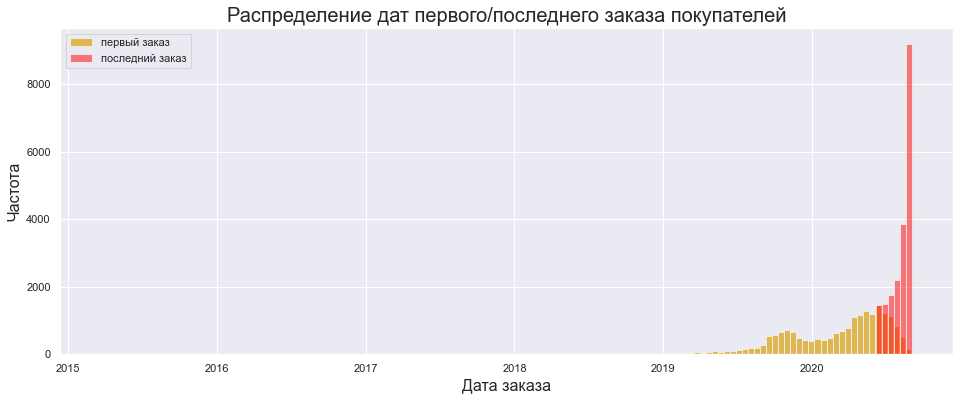

In [14]:
sns.histplot(first_last_user_date['first_order_date'], color='goldenrod')
sns.histplot(first_last_user_date['last_order_date'], color='red', bins=6, alpha=0.5)
plt.title('Распределение дат первого/последнего заказа покупателей', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16)
plt.legend(['первый заказ', 'последний заказ']);

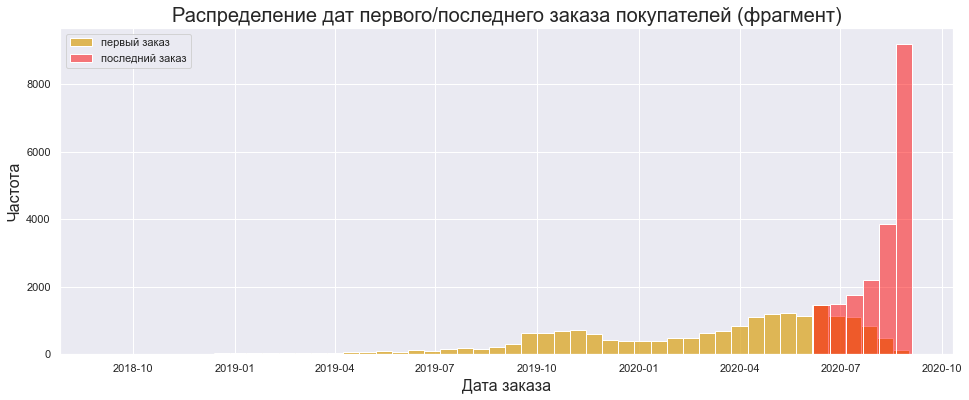

In [15]:
sns.histplot(first_last_user_date.query('first_order_date > "2018-09-01"')['first_order_date'], 
             color='goldenrod')
sns.histplot(first_last_user_date['last_order_date'], color='red', bins=6, alpha=0.5)
plt.title('Распределение дат первого/последнего заказа покупателей (фрагмент)', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16)
plt.legend(['первый заказ', 'последний заказ']);

In [16]:
# Дата отсечки
day_x = pd.to_datetime('2020-09-04')

In [17]:
#df сгруппированный по покупателю + заказу
user_order_count = df.pivot_table(index=['user_id', 'order_completed_at'], aggfunc={'cart': ('count', list)})
user_order_count['user_id_order'] = user_order_count.index
user_order_count = user_order_count.reset_index()
user_order_count.set_axis(['user_id', 'order_completed_at', 'cart_count', 'cart_list',
                          'user_id_order'], axis='columns', inplace=True)
user_order_count['cart_count'] = user_order_count['cart_count'].astype('int')
display(user_order_count)

,user_id,order_completed_at,cart_count,cart_list,user_id_order
0,0,2020-07-19 09:59:17,8,"[20, 82, 441, 57, 14, 405, 430, 379]","(0, 2020-07-19 09:59:17)"
1,0,2020-08-24 08:55:32,25,"[133, 5, 26, 10, 382, 14, 22, 41, 25, 441, 411...","(0, 2020-08-24 08:55:32)"
2,0,2020-09-02 07:38:25,11,"[803, 170, 84, 61, 440, 57, 55, 401, 398, 399,...","(0, 2020-09-02 07:38:25)"
3,1,2019-05-08 16:09:41,1,[55],"(1, 2019-05-08 16:09:41)"
4,1,2020-01-17 14:44:23,6,"[82, 798, 86, 421, 204, 55]","(1, 2020-01-17 14:44:23)"
...,...,...,...,...,...
209401,19998,2020-09-01 08:12:32,7,"[398, 57, 84, 61, 415, 6, 420]","(19998, 2020-09-01 08:12:32)"
209402,19998,2020-09-02 15:03:23,4,"[84, 798, 409, 19]","(19998, 2020-09-02 15:03:23)"
209403,19999,2020-08-31 18:54:24,1,[326],"(19999, 2020-08-31 18:54:24)"
209404,19999,2020-08-31 19:32:08,1,[326],"(19999, 2020-08-31 19:32:08)"


In [18]:
#даты заказов по покупателям
user_order_list = user_order_count.pivot_table(index=['user_id'], aggfunc={'order_completed_at': ('max', list)})
user_order_list.set_axis(['user_buy_date_list', 'last_order_date'], axis='columns', inplace=True)
user_order_list['second_to_last_order_date']=user_order_list.apply(second_to_last_date, axis=1)
display(user_order_list)

,user_buy_date_list,last_order_date,second_to_last_order_date
user_id,,,
0,"[2020-07-19 09:59:17, 2020-08-24 08:55:32, 202...",2020-09-02 07:38:25,2020-08-24 08:55:32
1,"[2019-05-08 16:09:41, 2020-01-17 14:44:23, 202...",2020-07-14 10:20:58,2020-05-24 11:13:59
2,"[2015-03-22 09:25:46, 2016-05-27 19:21:46, 201...",2020-06-18 18:31:08,2020-01-11 16:50:15
3,"[2015-06-18 16:15:33, 2015-07-04 14:05:22, 201...",2020-06-24 13:07:29,2020-06-12 14:49:01
4,"[2015-07-08 06:59:04, 2020-04-18 06:36:22, 202...",2020-08-27 13:54:48,2020-06-21 07:07:52
...,...,...,...
19995,"[2020-08-30 07:24:10, 2020-08-30 14:51:42, 202...",2020-08-30 14:57:36,2020-08-30 14:51:42
19996,"[2020-08-30 08:22:09, 2020-08-30 08:35:57, 202...",2020-09-02 07:45:27,2020-08-30 08:35:57
19997,"[2020-08-30 11:23:41, 2020-08-31 11:04:05, 202...",2020-08-31 11:48:23,2020-08-31 11:04:05


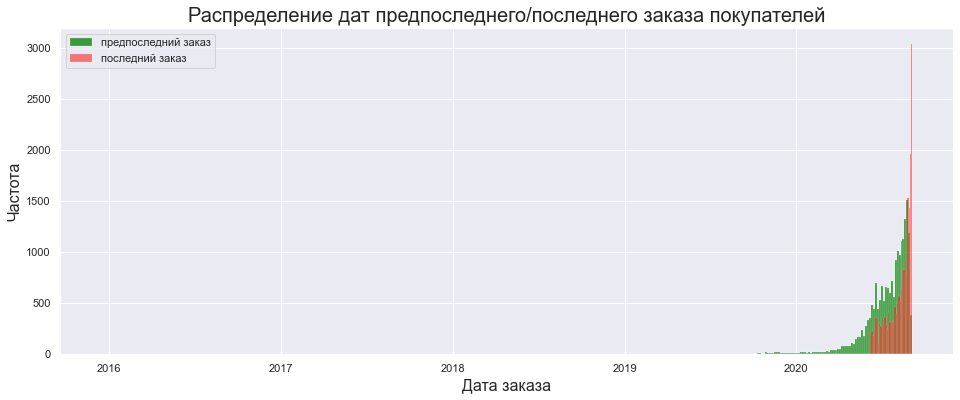

In [19]:
sns.histplot(user_order_list['second_to_last_order_date'], color='green')
sns.histplot(user_order_list['last_order_date'], color='red', alpha=0.5)
plt.title('Распределение дат предпоследнего/последнего заказа покупателей', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16)
plt.legend(['предпоследний заказ', 'последний заказ']);

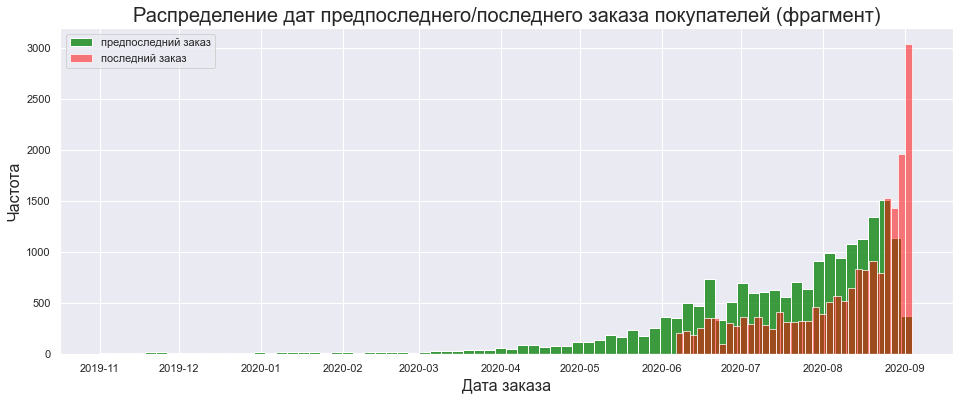

In [20]:
sns.histplot(user_order_list.query('second_to_last_order_date > "2019-11-01"')['second_to_last_order_date'],
             color='green')
sns.histplot(user_order_list['last_order_date'], color='red', alpha=0.5)
plt.title('Распределение дат предпоследнего/последнего заказа покупателей (фрагмент)', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16)
plt.legend(['предпоследний заказ', 'последний заказ']);

In [21]:
user_order_list['days_last_second_to_last'] = (user_order_list['last_order_date'] 
                                               - user_order_list['second_to_last_order_date']).dt.days

In [22]:
display(user_order_list.describe())
user_order_list['days_last_second_to_last'].quantile(0.90)

,days_last_second_to_last
count,20000.000000
mean,29.565550
std,49.025999
min,0.000000
25%,6.000000
50%,14.000000
75%,32.000000
max,1720.000000


68.0

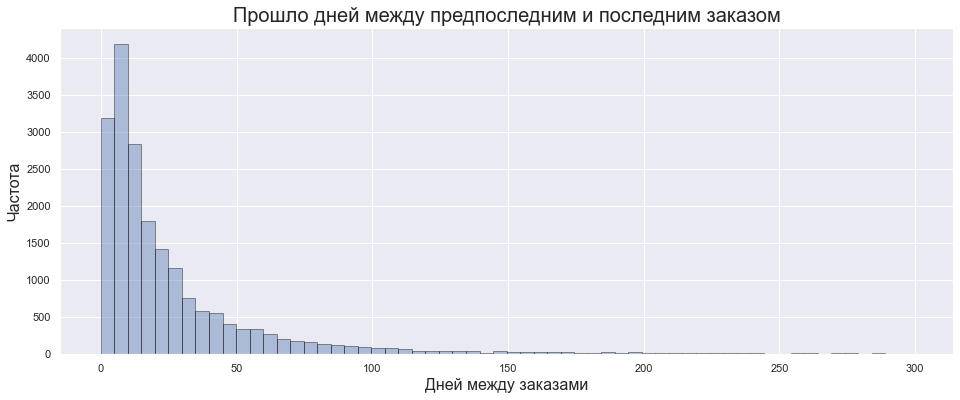

In [23]:
user_order_list['days_last_second_to_last'].plot.hist(
    range=(0, 299), bins=60, edgecolor='black', figsize=(16, 6), grid=True, alpha=0.4)

plt.title('Прошло дней между предпоследним и последним заказом', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Дней между заказами', fontsize=16);

In [24]:
#количество заказов покупателей до/после даты
for date in ['2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2019-09-04', '2020-01-01']:
    order_count_before = user_order_count[user_order_count['order_completed_at'] < date]
    order_count_after = user_order_count[user_order_count['order_completed_at'] > date]
    print(date, 'слева', len(order_count_before.index), len(order_count_before.index)/209406,
                'справа', len(order_count_after.index), len(order_count_after.index)/209406)

2016-01-01 слева 10 4.775412356857015e-05 справа 209396 0.9999522458764314
2017-01-01 слева 113 0.0005396215963248427 справа 209293 0.9994603784036752
2018-01-01 слева 737 0.0035194789070036197 справа 208669 0.9964805210929963
2019-01-01 слева 2422 0.011566048728307689 справа 206984 0.9884339512716923
2019-09-04 слева 9403 0.04490320239152651 справа 200003 0.9550967976084735
2020-01-01 слева 36922 0.1763177750398747 справа 172484 0.8236822249601253


#### Дата по категориям

In [25]:
#дата первого/последнего заказа категории
cart_first_last_date = df.pivot_table(index=['cart'], aggfunc={'order_completed_at': ('min', 'max')})
cart_first_last_date.set_axis(['last_cart_date', 'first_cart_date'], axis='columns', inplace=True)
cart_first_last_date

,last_cart_date,first_cart_date
cart,,
0,2020-09-03 21:34:35,2016-08-13 02:54:47
1,2020-09-03 11:26:45,2017-08-17 10:51:15
2,2020-08-22 22:04:57,2019-04-19 08:27:24
3,2018-09-16 08:14:25,2018-09-16 08:14:25
4,2020-08-27 17:58:25,2017-08-22 09:49:22
...,...,...
876,2020-08-25 18:24:36,2020-08-12 12:59:56
877,2020-08-26 19:30:19,2020-08-14 18:08:18
878,2020-08-27 11:31:29,2020-08-14 22:07:30


In [26]:
print('минимальная дата первого заказа категории', cart_first_last_date['first_cart_date'].min())
print('максимальная дата первого заказа категории', cart_first_last_date['first_cart_date'].max())
print('минимальная дата последнего заказа категории', cart_first_last_date['last_cart_date'].min())
print('максимальная дата последнего заказа категории', cart_first_last_date['last_cart_date'].max())

минимальная дата первого заказа категории 2015-03-22 09:25:46
максимальная дата первого заказа категории 2020-09-01 12:58:32
минимальная дата последнего заказа категории 2017-11-16 11:58:50
максимальная дата последнего заказа категории 2020-09-03 23:45:45


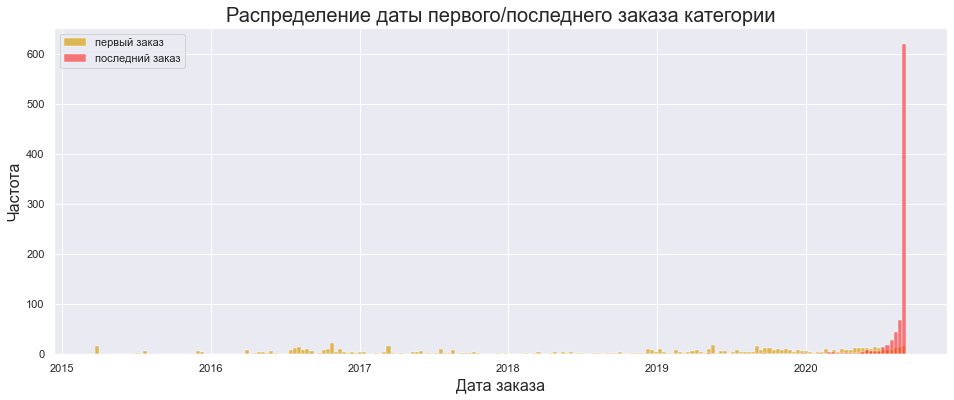

In [27]:
sns.histplot(cart_first_last_date['first_cart_date'], color='goldenrod', bins=200)
sns.histplot(cart_first_last_date['last_cart_date'], color='red', alpha=0.5, bins=100)
plt.title('Распределение даты первого/последнего заказа категории', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16)
plt.legend(['первый заказ', 'последний заказ']);

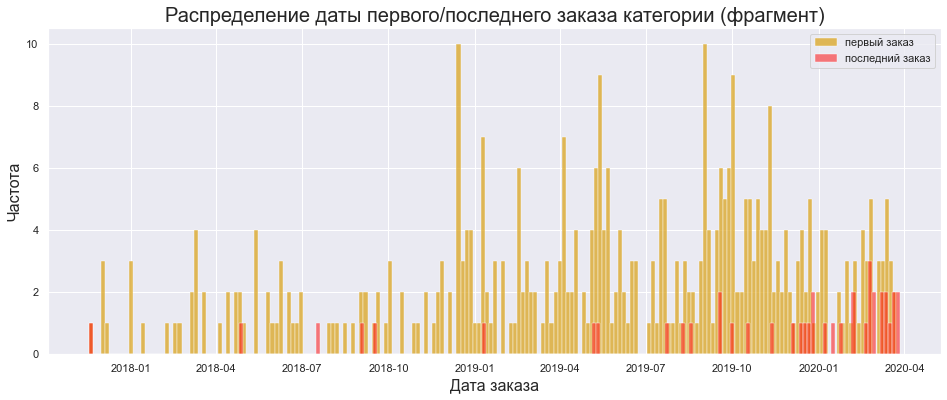

In [28]:
sns.histplot(cart_first_last_date.query(
    'first_cart_date > "2017-11-01" & first_cart_date < "2020-04-01"')['first_cart_date'], color='goldenrod', bins=200)
sns.histplot(cart_first_last_date.query(
    'last_cart_date > "2017-11-01" & last_cart_date < "2020-04-01"')['last_cart_date'], color='red', alpha=0.5, bins=200)
plt.title('Распределение даты первого/последнего заказа категории (фрагмент)', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16)
plt.legend(['первый заказ', 'последний заказ']);

### Покупатели

In [29]:
display(user_order_count)

,user_id,order_completed_at,cart_count,cart_list,user_id_order
0,0,2020-07-19 09:59:17,8,"[20, 82, 441, 57, 14, 405, 430, 379]","(0, 2020-07-19 09:59:17)"
1,0,2020-08-24 08:55:32,25,"[133, 5, 26, 10, 382, 14, 22, 41, 25, 441, 411...","(0, 2020-08-24 08:55:32)"
2,0,2020-09-02 07:38:25,11,"[803, 170, 84, 61, 440, 57, 55, 401, 398, 399,...","(0, 2020-09-02 07:38:25)"
3,1,2019-05-08 16:09:41,1,[55],"(1, 2019-05-08 16:09:41)"
4,1,2020-01-17 14:44:23,6,"[82, 798, 86, 421, 204, 55]","(1, 2020-01-17 14:44:23)"
...,...,...,...,...,...
209401,19998,2020-09-01 08:12:32,7,"[398, 57, 84, 61, 415, 6, 420]","(19998, 2020-09-01 08:12:32)"
209402,19998,2020-09-02 15:03:23,4,"[84, 798, 409, 19]","(19998, 2020-09-02 15:03:23)"
209403,19999,2020-08-31 18:54:24,1,[326],"(19999, 2020-08-31 18:54:24)"
209404,19999,2020-08-31 19:32:08,1,[326],"(19999, 2020-08-31 19:32:08)"


In [30]:
#количество заказов, среднее количество категорий в заказе, даты первого/последнего заказа покупателя
user_count = user_order_count.pivot_table(index=['user_id'], aggfunc={'order_completed_at': ('min', 'max'),  
                                                         'cart_count': ('count', 'mean')})
#user_count = user_order_count.reset_index()
user_count.set_axis(['user_buy_count', 'user_cart_count_mean', 
                     'user_buy_date_max', 'user_buy_date_min'], axis='columns', inplace=True)
display(user_count)

,user_buy_count,user_cart_count_mean,user_buy_date_max,user_buy_date_min
user_id,,,,
0,3.0,14.666667,2020-09-02 07:38:25,2020-07-19 09:59:17
1,9.0,4.111111,2020-07-14 10:20:58,2019-05-08 16:09:41
2,15.0,11.466667,2020-06-18 18:31:08,2015-03-22 09:25:46
3,7.0,8.857143,2020-06-24 13:07:29,2015-06-18 16:15:33
4,8.0,14.000000,2020-08-27 13:54:48,2015-07-08 06:59:04
...,...,...,...,...
19995,3.0,3.000000,2020-08-30 14:57:36,2020-08-30 07:24:10
19996,3.0,5.666667,2020-09-02 07:45:27,2020-08-30 08:22:09
19997,3.0,14.000000,2020-08-31 11:48:23,2020-08-30 11:23:41


In [31]:
#количество дней с первого/последнего заказа, среднее время между заказами покупателя.
user_count['first_buy_days_ago'] = (day_x - user_count['user_buy_date_min']).dt.days
user_count['last_buy_days_ago'] = (day_x - user_count['user_buy_date_max']).dt.days
user_count['first_last_buy_delta'] = user_count['first_buy_days_ago']  - user_count['last_buy_days_ago']
user_count['buy_delta_mean'] = user_count['first_last_buy_delta']/(user_count['user_buy_count']-1)
display(user_count)

,user_buy_count,user_cart_count_mean,user_buy_date_max,user_buy_date_min,first_buy_days_ago,last_buy_days_ago,first_last_buy_delta,buy_delta_mean
user_id,,,,,,,,
0,3.0,14.666667,2020-09-02 07:38:25,2020-07-19 09:59:17,46,1,45,22.500000
1,9.0,4.111111,2020-07-14 10:20:58,2019-05-08 16:09:41,484,51,433,54.125000
2,15.0,11.466667,2020-06-18 18:31:08,2015-03-22 09:25:46,1992,77,1915,136.785714
3,7.0,8.857143,2020-06-24 13:07:29,2015-06-18 16:15:33,1904,71,1833,305.500000
4,8.0,14.000000,2020-08-27 13:54:48,2015-07-08 06:59:04,1884,7,1877,268.142857
...,...,...,...,...,...,...,...,...
19995,3.0,3.000000,2020-08-30 14:57:36,2020-08-30 07:24:10,4,4,0,0.000000
19996,3.0,5.666667,2020-09-02 07:45:27,2020-08-30 08:22:09,4,1,3,1.500000
19997,3.0,14.000000,2020-08-31 11:48:23,2020-08-30 11:23:41,4,3,1,0.500000


In [32]:
user_count.describe()

,user_buy_count,user_cart_count_mean,first_buy_days_ago,last_buy_days_ago,first_last_buy_delta,buy_delta_mean
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10.470300,14.426739,199.143950,25.908900,173.235050,28.798111
std,11.905856,6.402802,161.804004,25.131721,161.131711,33.582145
min,3.000000,1.000000,2.000000,0.000000,0.000000,0.000000
25%,4.000000,10.111111,88.000000,5.000000,61.000000,10.400000
50%,6.000000,13.714286,150.000000,17.000000,126.000000,18.468627
75%,12.000000,18.000000,289.000000,42.000000,257.000000,34.000000
max,213.000000,64.400000,1992.000000,89.000000,1915.000000,866.500000


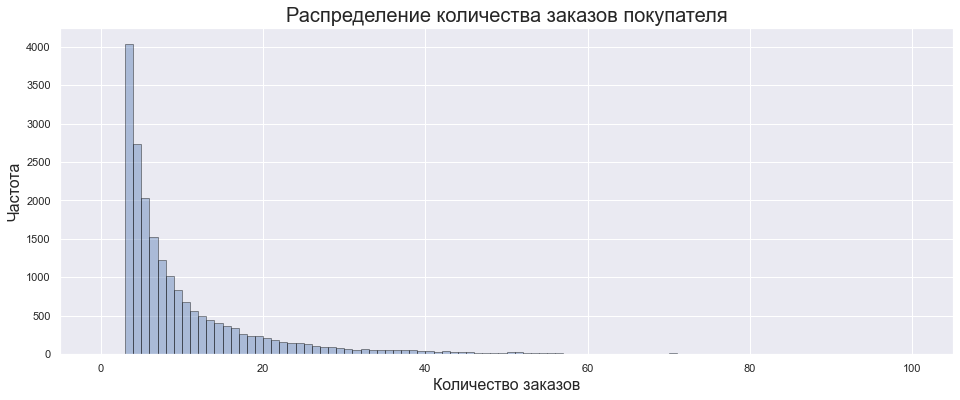

In [33]:
user_count['user_buy_count'].plot.hist(bins=100, range=(0, 100), edgecolor='black', figsize=(16, 6), grid=True, alpha=0.4)
plt.title('Распределение количества заказов покупателя', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Количество заказов', fontsize=16);

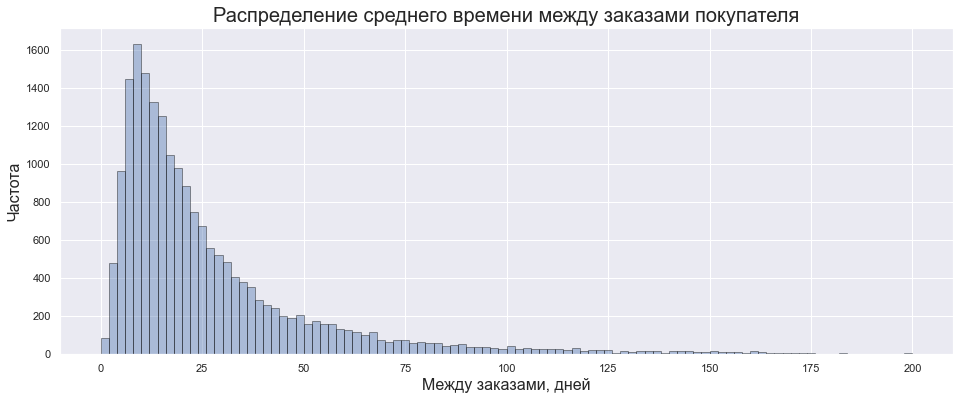

In [34]:
user_count['buy_delta_mean'].plot.hist(bins=100, range=(0, 200), edgecolor='black', figsize=(16, 6), grid=True, alpha=0.4)
plt.title('Распределение среднего времени между заказами покупателя', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Между заказами, дней', fontsize=16);

In [35]:
#сколько категорий (какие) в заказах покупателей
user_cart_list = df.pivot_table(index=['user_id'], 
                                aggfunc={'cart': (lambda x: list(x.unique()) , 'count', pd.Series.nunique)})
#user_count = user_order_count.reset_index()
user_cart_list.set_axis(['user_cart_list', 'user_cart', 'user_unique_cart'], axis='columns', inplace=True)
display(user_cart_list)

,user_cart_list,user_cart,user_unique_cart
user_id,,,
0,"[20, 82, 441, 57, 14, 405, 430, 379, 133, 5, 2...",44,36
1,"[55, 82, 798, 86, 421, 204, 23, 14, 231, 88, 1...",37,20
2,"[399, 14, 198, 88, 157, 82, 134, 16, 409, 384,...",172,74
3,"[399, 804, 134, 41, 712, 100, 382, 442, 62, 37...",62,38
4,"[54, 55, 22, 383, 384, 102, 98, 391, 100, 5, 6...",112,50
...,...,...,...
19995,"[67, 14, 398, 84, 57, 393, 31, 0, 712]",9,9
19996,"[393, 82, 92, 396, 84, 231, 61, 431, 404, 409,...",17,17
19997,"[443, 382, 383, 49, 77, 479, 218, 99, 203, 55,...",42,38


### Категории

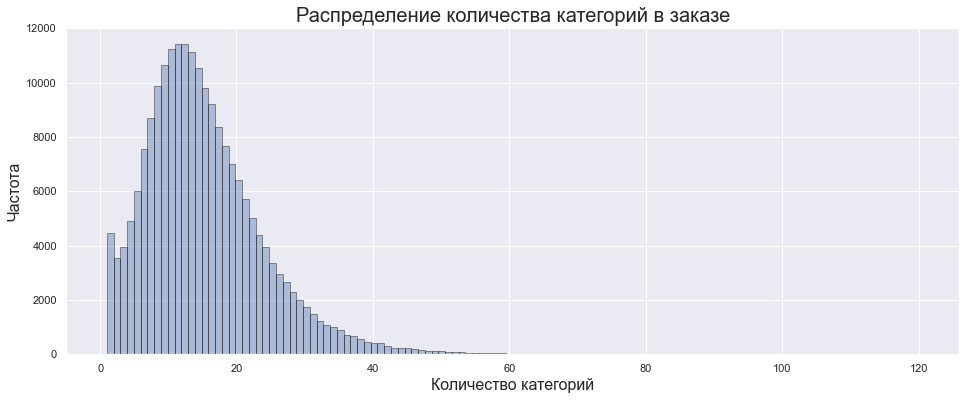

In [36]:
user_order_count['cart_count'].plot.hist(bins=120, edgecolor='black', figsize=(16, 6), grid=True, alpha=0.4)
plt.title('Распределение количества категорий в заказе', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Количество категорий', fontsize=16);

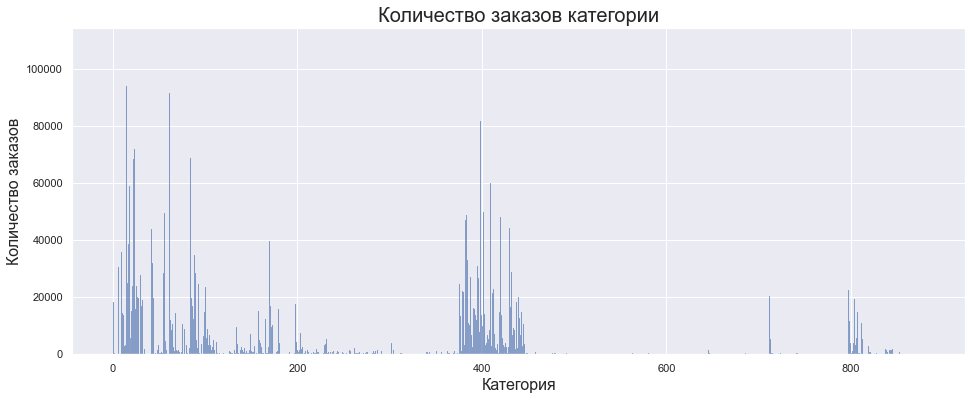

In [37]:
sns.histplot(df['cart'], bins=881)
plt.title('Количество заказов категории', fontsize=20) 
plt.ylabel('Количество заказов', fontsize=16)
plt.xlabel('Категория', fontsize=16);

In [38]:
#Количество заказов (всего) и покупателей (заказавших хотя бы раз) категории.
cart_count = df.pivot_table(index=['cart'], aggfunc={'user_id': ('count', pd.Series.nunique)})
cart_count.set_axis(['cart_buy_count', 'cart_buy_user_count'], axis='columns', inplace=True)
display(cart_count)

,cart_buy_count,cart_buy_user_count
cart,,
0,18387,8076
1,357,217
2,30,25
3,1,1
4,219,190
...,...,...
876,2,2
877,5,4
878,6,6


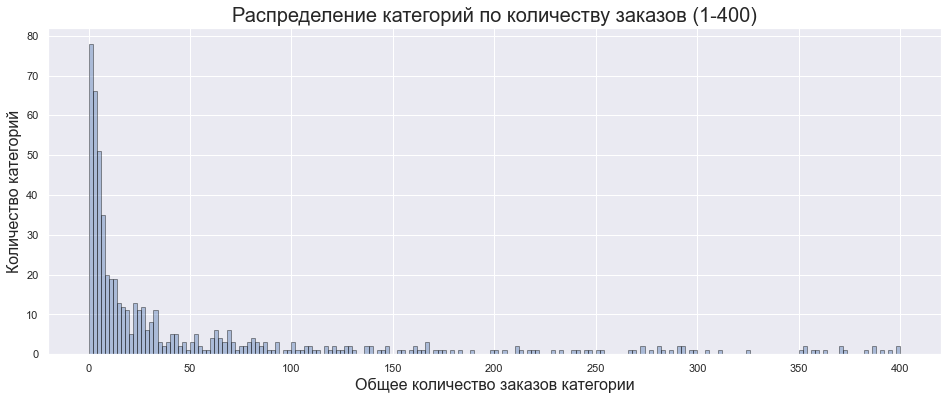

In [39]:
cart_count['cart_buy_count'].plot.hist(range=(0, 400), bins=200, edgecolor='black', figsize=(16, 6), grid=True, alpha=0.4)
plt.title('Распределение категорий по количеству заказов (1-400)', fontsize=20) 
plt.ylabel('Количество категорий', fontsize=16)
plt.xlabel('Общее количество заказов категории', fontsize=16);

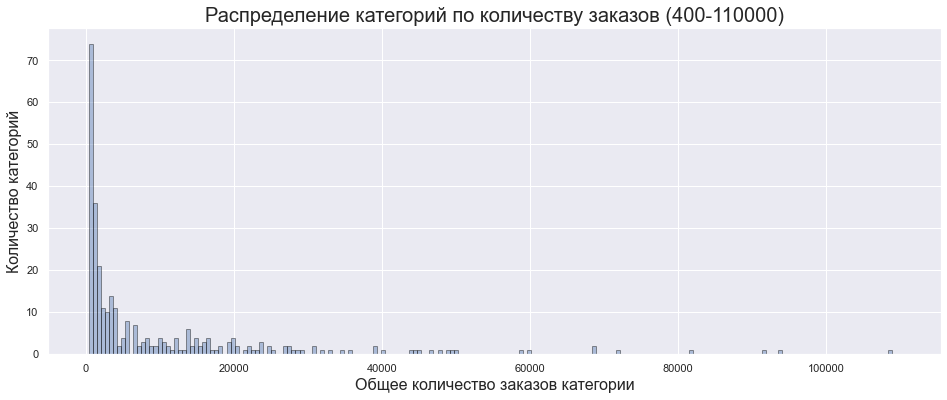

In [40]:
cart_count['cart_buy_count'].plot.hist(range=(400, 110000), bins=200, edgecolor='black', figsize=(16, 6), grid=True, alpha=0.4)
plt.title('Распределение категорий по количеству заказов (400-110000)', fontsize=20) 
plt.ylabel('Количество категорий', fontsize=16)
plt.xlabel('Общее количество заказов категории', fontsize=16);

In [41]:
cart_count.describe()

,cart_buy_count,cart_buy_user_count
count,881.000000,881.000000
mean,3544.908059,1268.558456
std,10686.317664,2812.280068
min,1.000000,1.000000
25%,7.000000,6.000000
50%,66.000000,60.000000
75%,1101.000000,801.000000
max,108877.000000,16994.000000


### data_sample_submission

In [42]:
sample_sub

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0
...,...,...
790444,19998;26,0
790445,19998;31,0
790446,19998;29,1
790447,19998;798,1


In [43]:
sample_sub[['user_id','cart']] = sample_sub['id'].str.split(';', expand=True)
sample_sub

,id,target,user_id,cart
0,0;133,0,0,133
1,0;5,1,0,5
2,0;10,0,0,10
3,0;396,1,0,396
4,0;14,0,0,14
...,...,...,...,...
790444,19998;26,0,19998,26
790445,19998;31,0,19998,31
790446,19998;29,1,19998,29
790447,19998;798,1,19998,798


In [44]:
print('дубликатов:', sample_sub.duplicated().sum())
print()
print('кол-во уникальных покупателей:', sample_sub['user_id'].nunique())
print()
print('кол-во уникальных категорий:', sample_sub['cart'].nunique())

дубликатов: 0

кол-во уникальных покупателей: 13036

кол-во уникальных категорий: 858


### Выводы по данным  

* Пропусков нет, дубликатов нет

* Странный пик заказов 20 июня 2020 и провал 22-23 июня 2020
* Покупок до 2019г. - 1.1%, до 2020г. - 18%
* Дата отсечки - 03.09.2020

* 20 000 покупателей 
  *            последняя покупка не ранее 90 дней до отсечки (06,06,2020 - 03,09,2020)
  *            покупок не менее 3
* Половина покупателей делает заказ раз в месяц и чаще
* В большинстве случаев следующий заказ стоит ждать не позднее 30 (60) дней
* Медианное количество заказов покупателя - 6
* Медианное количество категорий в заказе покупателя - 14 (доходит до 64)

* 881 категория товаров
  * Новые категории вводились на протяжении всего периода (есть совсем свежие)
  * Часть категорий не покупалась с конца 2017г (16.11.2017) и далее - возможно выведены 
* Есть очень популярные (18 категорий с продажами более 40000)  
и крайне редкие категории (половина категорий куплена менее 66 раз)

* Предсказание необходимо для 858 категорий из 881 (97%) и 13036 покупателей из 20000 (65%)

## Подготовка признаков

Вижу два варианта выделение целевой покупки:
* по номеру покупки - брать в качестве target последнюю, предпоследнюю и т.д. покупки
* по дате - отсекать выборку по определенной дате и брать в качестве target первую покупку после неё.

|  | Плюсы | Минусы |
| ---: | :--- | :--- |
| По номеру:| Максимальный объем обучающих данных | Часть данных не актуальна (для некоторых покупателей 2 покупка уже очень давно) |
|  |  | Нет привязки к дате. |

|  | Плюсы | Минусы |
| ---: | :--- | :--- |
| По дате: | Повторяет условия задачи | Теряется значительная часть строк (нет целевой покупки или несколько покупок после даты) |
|  | Легко ввести сезонные признаки для категории |  |

In [45]:
#Нумеруем заказы покупателей от последнего к первому
df = df.merge(user_order_list['user_buy_date_list'], on=['user_id'], how='outer')
df['reverse_buy_num'] = df.apply(buy_num, axis=1)
df = df.drop('user_buy_date_list', axis=1)

### По номеру покупки

In [46]:
df_train = pd.DataFrame()

In [47]:
#Обрезаем данные по номеру покупки (нумерация обратная)
for cut_num in [0, 1, 2, 3, 4, 5, 6]:  #, 7, 8, 9, 10, 11
    df_cut = df[df['reverse_buy_num'] > cut_num]

    # Признаки покупателя + категории
    df_train_1 = df_cut.pivot_table(index=['user_id', 'cart'], aggfunc={'order_completed_at': (min, max), 
                                                                  'reverse_buy_num': ('count')})
    df_train_1 = df_train_1.reset_index()
    df_train_1.set_axis(['user_id', 'cart', 'user_cart_date_max', 'user_cart_date_min', 
                                      'user_cart_buy_count'], axis='columns', inplace=True)

    if cut_num > 0:
        #Целевой признак
        df_target = df[df['reverse_buy_num'] == cut_num]
        df_target = df_target.pivot_table(index=['user_id', 'cart'], aggfunc={'reverse_buy_num': ('count')}).reset_index()
        df_train_1['target'] = df_train_1.merge(df_target, how='left', on=['user_id', 'cart'])['reverse_buy_num'].fillna(0)

        #количество вхождений категории в последние 1, 2, 3, 5, 7, 10 заказов покупателя
    for order_num in [1, 2, 3, 5, 7, 10]:
        df_norder = df_cut[df_cut['reverse_buy_num'] <= order_num + cut_num]
        df_norder = df_norder.pivot_table(index=['user_id', 'cart'], aggfunc={'reverse_buy_num': ('count')})
        col_name = 'in_last' + str(order_num)
        df_train_1[col_name] = df_train_1.merge(df_norder,how='left',on=['user_id','cart'])['reverse_buy_num'].fillna(0)


    #признаки покупателя
    df_train_2 = df_cut.pivot_table(index=['user_id'], aggfunc={'reverse_buy_num': (pd.Series.nunique), 
                                            'order_completed_at': (min, max), 
                                            'cart': ('count', pd.Series.nunique)})
    df_train_2 = df_train_2.reset_index()
    df_train_2.set_axis(['user_id', 'user_cart_count', 'user_cart_nunique',
                    'user_last_date', 'user_first_date', 'user_order_count'], axis='columns', inplace=True)
    df_train_2['user_cart_mean'] = df_train_2['user_cart_count']/df_train_2['user_order_count']
    df_train_2['user_lifetime'] = (df_train_2['user_last_date'].astype('datetime64') - 
                                df_train_2['user_first_date'].astype('datetime64')).dt.days
    df_train_2 = df_train_2.drop(['user_last_date', 'user_first_date'], axis=1)

        # даты последних заказов покупателя
    df_user_order_dates = df[df['reverse_buy_num'] > cut_num]
    df_user_order_dates = df_user_order_dates[df_user_order_dates['reverse_buy_num'] <= cut_num+10]
    df_user_order_dates = df_user_order_dates.pivot_table(index=['user_id'],
                                                      columns=['reverse_buy_num'],
                                                      aggfunc={'order_completed_at': (min)})
    df_user_order_dates = df_user_order_dates.reset_index()
    df_user_order_dates.set_axis(['user_id', 'user_last_order_date', 'last2', 'last3', 'last4', 'last5', 
                              'last6', 'last7', 'last8', 'last9', 'last10'], axis='columns', inplace=True)

        # дней между последним и 2-10 заказами
    for col in ['last2', 'last3', 'last4', 'last5', 'last6', 'last7', 'last8', 'last9', 'last10']:
        df_user_order_dates[col] = (df_user_order_dates['user_last_order_date'].astype('datetime64') - 
                                df_user_order_dates[col].astype('datetime64')).dt.days

        # оставляем дельту для последнего и 2, 3, 5, 7, 10 заказов
    for col in ['last4', 'last6', 'last8', 'last9']:
        df_user_order_dates = df_user_order_dates.drop(col, axis=1)
    df_user_order_dates.set_axis(['user_id', 'user_last_order_date', 'delta2',
                              'delta3','delta5','delta7','delta10'], axis='columns', inplace=True)

        #пропуски заполним значением 1000 лет
    df_user_order_dates = df_user_order_dates.fillna(365000)

    df_train_2 = df_train_2.merge(df_user_order_dates, how='inner', on='user_id')

    
    #признаки категории
    df_train_3 = df_cut.pivot_table(index=['cart'], aggfunc={'order_completed_at': (min, max),
                                                         'user_id': ('count', pd.Series.nunique),
                 'reverse_buy_num': (lambda x: np.quantile(x, 0.25)-cut_num, lambda x: np.quantile(x, 0.1)-cut_num)})
    df_train_3.set_axis(['cart_last_date', 'cart_first_date', 'cart_buy_num_q25', 'cart_buy_num_q10',
                     'cart_order_count','cart_user_count'], axis='columns', inplace=True)
    df_train_3['cart_reord_coef'] = df_train_3['cart_order_count'] / df_train_3['cart_user_count']

        #количество вхождений категории в последние 1, 2, 3, 5, 7, 10 заказов (по всем покупателям)
    for order_num in [1, 2, 3, 5, 7, 10]:
        df_norder = df_cut[df_cut['reverse_buy_num'] <= order_num + cut_num]
        df_norder = df_norder.pivot_table(index=['cart'], aggfunc={'reverse_buy_num': ('count')})
        col_name = 'cart_in_last' + str(order_num)
        df_train_3[col_name] = df_train_3.merge(
            df_norder, how='left', on='cart')['reverse_buy_num'] / df_train_3['cart_order_count']
    df_train_3 = df_train_3.fillna(0)

    #объединяем признаки
    df_train_0 = df_train_1.merge(df_train_2, how='left', on='user_id')
    df_train_0 = df_train_0.merge(df_train_3, how='left', on='cart')

    # Вычисляемые признаки покупателя + категории 
    df_train_0['user_cart_ratio'] = df_train_0['user_cart_buy_count']/df_train_0['user_order_count']
    cart_more1 = df_train_0[df_train_0['user_cart_buy_count']>1].groupby('cart')['user_id'].count()
    df_train_0['cart_more1_ratio'] = df_train_0.loc[:, 'cart':'user_cart_date_max'].merge(
                                             cart_more1, how='left', on='cart')['user_id']/df_train_0['cart_user_count']
    df_train_0 = df_train_0.fillna(0)
    
    #даты к числам
    df_train_0['user_cart_date_max'] = (df_train_0['user_last_order_date'] - df_train_0['user_cart_date_max']).dt.days
    df_train_0['user_cart_date_min'] = (df_train_0['user_last_order_date'] - df_train_0['user_cart_date_min']).dt.days
    df_train_0['cart_last_date'] = (df_train_0['user_last_order_date'] - df_train_0['cart_last_date']).dt.days
    df_train_0['cart_first_date'] = (df_train_0['user_last_order_date'] - df_train_0['cart_first_date']).dt.days
    df_train_0 = df_train_0.drop('user_last_order_date', axis=1)
    
    #признаки для прогноза
    if cut_num == 0:
        data_pred = df_train_0.copy()
    
    #отрезаем тестовую выборку
    elif cut_num == 1:
        df_FINAL_train = df_train_0.copy()
        data_train, data_test = train_test_split(df_train_0, test_size=0.99999, random_state=123)
    
    #обогащаем тренировочные выборки данными более ранних продаж
    else:
        data_train = pd.concat([data_train, df_train_0])
        df_FINAL_train = pd.concat([df_FINAL_train, df_train_0])

In [48]:
data_train.head(3)

,user_id,cart,user_cart_date_max,user_cart_date_min,user_cart_buy_count,target,in_last1,in_last2,in_last3,in_last5,in_last7,in_last10,user_cart_count,user_cart_nunique,user_order_count,user_cart_mean,user_lifetime,delta2,delta3,delta5,delta7,delta10,cart_last_date,cart_first_date,cart_buy_num_q25,cart_buy_num_q10,cart_order_count,cart_user_count,cart_reord_coef,cart_in_last1,cart_in_last2,cart_in_last3,cart_in_last5,cart_in_last7,cart_in_last10,user_cart_ratio,cart_more1_ratio
653418,10374,421,101,101,1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,104,64,5,20.8,101,19.0,20.0,101.0,365000.0,365000.0,-47,1379,3.0,1.0,12678,5829,2.174987,0.100726,0.205868,0.298075,0.431141,0.529973,0.643477,0.20,0.446560
990803,18641,14,0,0,1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,42,38,2,21.0,18,18.0,365000.0,365000.0,365000.0,365000.0,-30,1962,3.0,1.0,85164,15273,5.576115,0.100970,0.202703,0.283946,0.412040,0.507785,0.615354,0.50,0.769332
670737,10733,0,36,36,1,0.0,0.0,1.0,1.0,1.0,1.0,1.0,32,21,4,8.0,87,36.0,62.0,365000.0,365000.0,365000.0,-76,1406,3.0,1.0,16494,7339,2.247445,0.112829,0.219777,0.302110,0.425427,0.519825,0.624227,0.25,0.453059


In [49]:
data_test.head(3)

,user_id,cart,user_cart_date_max,user_cart_date_min,user_cart_buy_count,target,in_last1,in_last2,in_last3,in_last5,in_last7,in_last10,user_cart_count,user_cart_nunique,user_order_count,user_cart_mean,user_lifetime,delta2,delta3,delta5,delta7,delta10,cart_last_date,cart_first_date,cart_buy_num_q25,cart_buy_num_q10,cart_order_count,cart_user_count,cart_reord_coef,cart_in_last1,cart_in_last2,cart_in_last3,cart_in_last5,cart_in_last7,cart_in_last10,user_cart_ratio,cart_more1_ratio
148452,2079,798,75,293,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,824,177,36,22.888889,324,5,10.0,18.0,25.0,39.0,-6,1564,3.0,1.0,20433,9296,2.198042,0.106641,0.216561,0.302403,0.438066,0.537170,0.647090,0.083333,0.474613
765502,12728,100,0,83,4,1.0,1.0,1.0,2.0,2.0,2.0,3.0,180,66,14,12.857143,104,28,35.0,50.0,55.0,77.0,-29,1460,3.0,2.0,21518,4924,4.370024,0.091179,0.182127,0.258156,0.380519,0.476438,0.589599,0.285714,0.624898
146062,2044,141,53,53,1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,533,119,16,33.312500,253,21,53.0,81.0,99.0,148.0,-14,1094,3.0,1.0,637,451,1.412417,0.102041,0.207221,0.298273,0.409733,0.516484,0.585557,0.062500,0.208426


In [50]:
df_FINAL_train.head(3)

,user_id,cart,user_cart_date_max,user_cart_date_min,user_cart_buy_count,target,in_last1,in_last2,in_last3,in_last5,in_last7,in_last10,user_cart_count,user_cart_nunique,user_order_count,user_cart_mean,user_lifetime,delta2,delta3,delta5,delta7,delta10,cart_last_date,cart_first_date,cart_buy_num_q25,cart_buy_num_q10,cart_order_count,cart_user_count,cart_reord_coef,cart_in_last1,cart_in_last2,cart_in_last3,cart_in_last5,cart_in_last7,cart_in_last10,user_cart_ratio,cart_more1_ratio
0,0,5,0,0,1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,33,27,2,16.5,35,35.0,365000.0,365000.0,365000.0,365000.0,-11,1461,3.0,1.0,27790,10769,2.580555,0.100396,0.203454,0.286686,0.414070,0.510579,0.619647,0.5,0.532919
1,0,10,0,0,1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,33,27,2,16.5,35,35.0,365000.0,365000.0,365000.0,365000.0,-10,1727,3.0,2.0,13307,4839,2.749948,0.095138,0.192079,0.270159,0.390697,0.482753,0.589690,0.5,0.485431
2,0,14,0,35,2,0.0,1.0,2.0,2.0,2.0,2.0,2.0,33,27,2,16.5,35,35.0,365000.0,365000.0,365000.0,365000.0,-11,1981,3.0,1.0,85164,15273,5.576115,0.100970,0.202703,0.283946,0.412040,0.507785,0.615354,1.0,0.769332


In [51]:
data_pred.head(3)

,user_id,cart,user_cart_date_max,user_cart_date_min,user_cart_buy_count,in_last1,in_last2,in_last3,in_last5,in_last7,in_last10,user_cart_count,user_cart_nunique,user_order_count,user_cart_mean,user_lifetime,delta2,delta3,delta5,delta7,delta10,cart_last_date,cart_first_date,cart_buy_num_q25,cart_buy_num_q10,cart_order_count,cart_user_count,cart_reord_coef,cart_in_last1,cart_in_last2,cart_in_last3,cart_in_last5,cart_in_last7,cart_in_last10,user_cart_ratio,cart_more1_ratio
0,0,5,8,8,1,0.0,1.0,1.0,1.0,1.0,1.0,44,36,3,14.666667,44,8,44,365000.0,365000.0,365000.0,-2,1470,3.0,2.0,30753,11781,2.610390,0.096348,0.187071,0.280200,0.417585,0.517933,0.626313,0.333333,0.551821
1,0,10,8,8,1,0.0,1.0,1.0,1.0,1.0,1.0,44,36,3,14.666667,44,8,44,365000.0,365000.0,365000.0,-2,1736,3.0,2.0,14579,5291,2.755434,0.087249,0.174086,0.262569,0.394952,0.487825,0.596886,0.333333,0.497448
2,0,14,8,44,2,0.0,1.0,2.0,2.0,2.0,2.0,44,36,3,14.666667,44,8,44,365000.0,365000.0,365000.0,-2,1990,3.0,2.0,93957,16037,5.858764,0.093585,0.185106,0.277318,0.413242,0.512607,0.622370,0.666667,0.813868


#### Расшифровка признаков

**Признаки покупателя + категории**
* **user_cart_date_max** - Дата последней покупки категории покупателем (Дней от последней покупки кат до посл. заказа)
* **user_cart_date_min** - Дата первой покупки категории покупателем (Дней от первой покупки кат до посл. заказа)
* **user_cart_buy_count** - Суммарное количество вхождений категории в заказы покупателя
* **target** - Наличие категории в целевой покупке 
* **in_lastN** - Количество вхождений категории в N последних заказов

**Признаки покупателя**
* **user_cart_count** - сумма категорий во всех заказах
* **user_cart_nunique** - количество уникальных категорий заказанных покупателем хотя бы 1 раз
* **user_order_count** - количество заказов покупателя
* **user_cart_mean** - в среднем категорий в заказе
* **user_lifetime** - дней от первого до последнего заказа покупателя
* **user_last_order_date** - дата последнего заказа покупателя
* **deltaN** - дней между последним и N-ым заказом покупателя

**Признаки категории**
* **cart_last_date** - Дата последнего заказа категории
* **cart_first_date** -	Дата "рождения" категории 
* **cart_buy_num_q25** - Четверть заказов категории в покупках позднее значения (0,25 квантиль номера заказа)
* **cart_buy_num_q10** - 10% заказов категории в покупках позднее значения (0,25 квантиль номера заказа)
* **cart_order_count** - Общее количество заказов категории
* **cart_user_count** - Пользователей заказывало категорию
* **cart_reord_coef** - Среднее число заказов пользователем (из заказывавших)
* **cart_in_lastN** - Среднее число заказов среди N последних заказов заказах

**Вычисляемые признаки покупателя + категории**
* **user_cart_ratio** - Доля вхождений категории в заказы покупателя
* **cart_more1_ratio** - Доля покупателей купивших категорию более 1 раза

### По дате покупки (способ пока не реализован)

In [52]:
#day_x

In [53]:
#обрезаем покупки по дате (15, 30, 60, 90)
'''
cut_date = day_x - datetime.timedelta(days=60)
df_date_cut = df[df['order_completed_at'] < cut_date]

df_date_target = df[df['order_completed_at'] >= cut_date]
# номер целевого заказа (обратный) покупателя (первая покупка после cut_date)
user_targ_num = df_date_target.pivot_table(index=['user_id'], aggfunc={'reverse_buy_num': (max)})
user_targ_num['reverse_buy_num'].value_counts()

user_targ_num
'''

"\ncut_date = day_x - datetime.timedelta(days=60)\ndf_date_cut = df[df['order_completed_at'] < cut_date]\n\ndf_date_target = df[df['order_completed_at'] >= cut_date]\n# номер целевого заказа (обратный) покупателя (первая покупка после cut_date)\nuser_targ_num = df_date_target.pivot_table(index=['user_id'], aggfunc={'reverse_buy_num': (max)})\nuser_targ_num['reverse_buy_num'].value_counts()\n\nuser_targ_num\n"

### Варианты обучающих и тестовых данных
Вижу два варианта данных для валидации:
* 1.Полный набор строк (data_train, data_test, df_FINAL_train, data_pred)
* 2.Строки аналогичные условиям отбора в 'train.csv' (*последняя продажа не ранее 90 дней, покупатели с 3 и более заказами*)

In [54]:
data_train_similar = data_train.query('delta2 <= 90 and user_order_count > 2')
data_test_similar = data_test.query('delta2 <= 90 and user_order_count > 2')
df_FINAL_train_similar = df_FINAL_train.query('delta2 <= 90 and user_order_count > 2')

### Анализ признаков 

#### Баланс классов

In [55]:
#баланс классов
class_count = [0, 0]
for cl in [0, 1]:
    class_count[cl] = data_train[data_train['target']==cl]['target'].count()

print('Класс 0:', class_count[0])
print('Класс 1:', class_count[1])
print('Соотношение 0/1:', class_count[0]/class_count[1])

Класс 0: 2890283
Класс 1: 674112
Соотношение 0/1: 4.287541239437957


In [56]:
#баланс классов
class_count_0 = data_train[data_train['target']==0]['target'].count()
class_count_1 = data_train[data_train['target']==1]['target'].count()

print('Класс 0:', class_count_0)
print('Класс 1:', class_count_1)
print('Соотношение 0/1:', class_count_0/class_count_1)

Класс 0: 2890283
Класс 1: 674112
Соотношение 0/1: 4.287541239437957


#### Взаимосвязь признаков

In [57]:
t_corr = data_train.corr()['target'].sort_values(ascending=False)
t_corr

target                 1.000000
in_last5               0.359064
in_last7               0.356890
user_cart_ratio        0.350587
in_last10              0.342694
in_last3               0.340535
cart_reord_coef        0.326583
cart_order_count       0.314510
in_last2               0.310689
cart_more1_ratio       0.298487
cart_user_count        0.277663
in_last1               0.249067
user_cart_buy_count    0.210844
cart_first_date        0.156260
delta7                 0.118885
delta10                0.116599
delta5                 0.114766
delta3                 0.097001
delta2                 0.074235
user_cart_mean         0.064335
user_id                0.058483
cart_buy_num_q25      -0.003270
cart_in_last1         -0.003775
cart_in_last2         -0.005897
cart_in_last3         -0.007181
cart_in_last5         -0.010421
cart_in_last7         -0.010597
cart_buy_num_q10      -0.012151
cart_in_last10        -0.013280
user_cart_date_min    -0.019772
cart_last_date        -0.077448
user_car

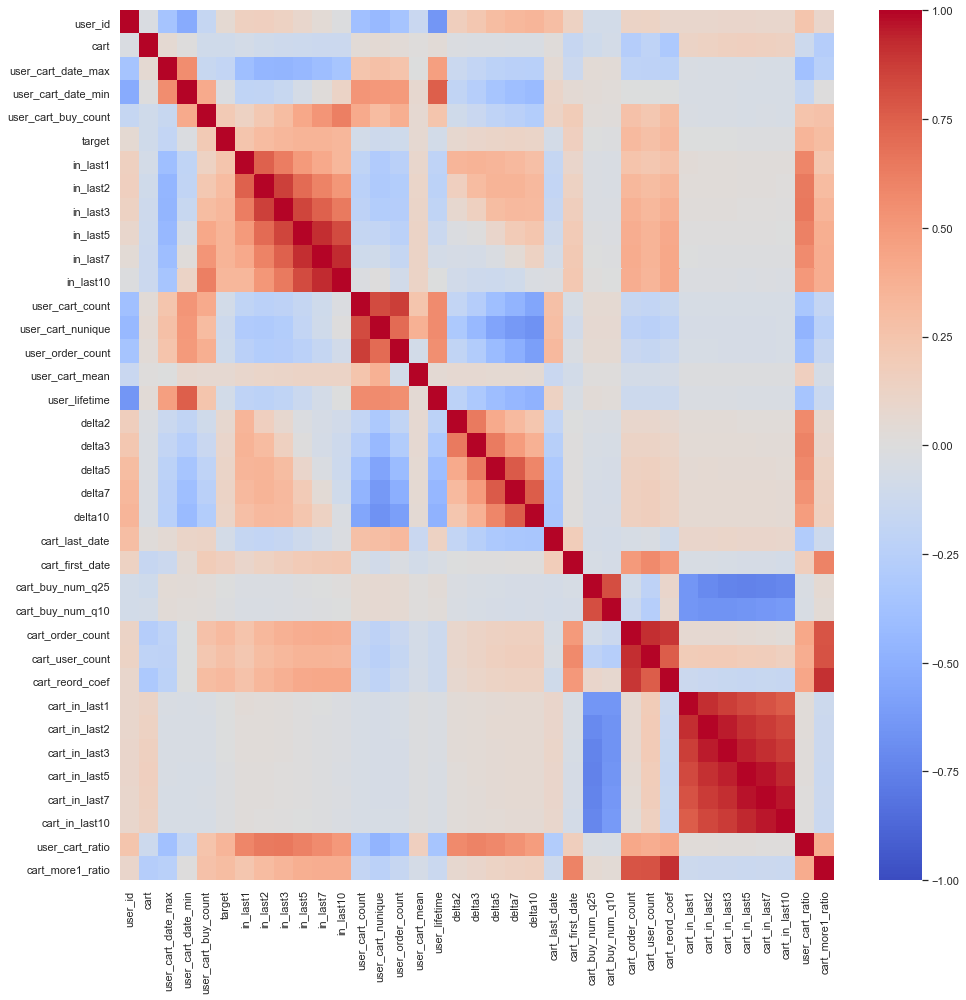

In [58]:
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(data_train.corr(), annot = False, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm');

In [59]:
#блок попарно получает значения корреляции и находит n наибольших

def get_red_pair(df):
    '''
    функция принимает df и возвращает множество пар признаков
    '''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_largest_correlations(df, n=30):
    '''
    функция принимает df и возвращает series с n наибольшими значениями 
    '''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_red_pair(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

corr = get_largest_correlations(data_train)
print(corr)

cart_in_last5     cart_in_last7        0.970439
cart_in_last7     cart_in_last10       0.967254
cart_in_last2     cart_in_last3        0.958195
cart_in_last3     cart_in_last5        0.951686
cart_in_last5     cart_in_last10       0.932705
in_last7          in_last10            0.928247
in_last5          in_last7             0.919910
cart_in_last3     cart_in_last7        0.919891
cart_order_count  cart_user_count      0.918158
cart_in_last1     cart_in_last2        0.914865
cart_reord_coef   cart_more1_ratio     0.912366
cart_in_last2     cart_in_last5        0.909618
cart_order_count  cart_reord_coef      0.894878
cart_in_last3     cart_in_last10       0.881618
cart_in_last2     cart_in_last7        0.878405
cart_in_last1     cart_in_last3        0.873021
user_cart_count   user_order_count     0.868707
in_last2          in_last3             0.864408
in_last3          in_last5             0.847798
cart_in_last2     cart_in_last10       0.840120
cart_in_last1     cart_in_last5        0

In [60]:
#kfold = KFold(n_splits=5, random_state=123, shuffle=True)

### Списки признаков

In [61]:
# полный
feat_full = data_train.columns.tolist()
feat_full.remove('target')

# исключены категориальные 'user_id', 'cart' и неудачный 'cart_more1_ratio'
feat_full3 = data_train.columns.tolist()
for col in ['target', 'user_id', 'cart', 'cart_more1_ratio']:
    feat_full3.remove(col)

feat_full2 = feat_full3.copy()
for col in ['user_cart_ratio']:
    feat_full2.remove(col)

# короткий
feat_xs = ['user_id', 'cart', 'user_cart_date_max', 'user_cart_date_min', 'in_last1', 'in_last3', 'user_lifetime',
           'delta2', 'cart_reord_coef', 'user_cart_ratio']

# исключены коррелирующие признаки
feat_smart = ['user_cart_date_max', 'user_cart_date_min', 'user_cart_buy_count', 'in_last1', 'in_last2', 'in_last5', 
              'user_cart_count', 'user_order_count', 'user_cart_mean', 'delta2', 'delta5', 'cart_last_date', 
              'cart_first_date', 'cart_buy_num_q25', 'cart_buy_num_q10', 'cart_reord_coef', 'cart_in_last1', 
              'cart_in_last2', 'cart_in_last10']

feat_smart2 = ['user_cart_date_max', 'user_cart_date_min', 'user_cart_buy_count', 'in_last1', 'in_last2', 'in_last5', 
              'user_cart_count', 'user_order_count', 'user_cart_mean', 'delta2', 'delta5', 'cart_last_date', 
              'cart_first_date', 'cart_buy_num_q25', 'cart_buy_num_q10', 'cart_reord_coef', 'cart_in_last1', 
              'cart_in_last2', 'cart_in_last10', 'user_cart_ratio']

feat_smart2_cat = ['user_id', 'cart',
              'user_cart_date_max', 'user_cart_date_min', 'user_cart_buy_count', 'in_last1', 'in_last2', 'in_last5', 
              'user_cart_count', 'user_order_count', 'user_cart_mean', 'delta2', 'delta5', 'cart_last_date', 
              'cart_first_date', 'cart_buy_num_q25', 'cart_buy_num_q10', 'cart_reord_coef', 'cart_in_last1', 
              'cart_in_last2', 'cart_in_last10', 'user_cart_ratio']

# 10 признаков
feat_10 = ['in_last5', 'cart_reord_coef', 'in_last1', 'user_cart_buy_count', 'delta10', 'cart_buy_num_q25', 
           'cart_last_date', 'user_cart_nunique', 'user_order_count', 'user_cart_date_max']

# 20 признаков
feat_20 = ['cart_reord_coef','cart_order_count','cart_user_count', 'in_last10','user_cart_nunique', 
           'user_cart_date_max', 'user_cart_mean', 'user_order_count', 'in_last1', 'user_cart_buy_count', 
           'delta10', 'user_cart_date_min', 'user_cart_count', 'cart_buy_num_q10', 'user_id', 'cart_first_date', 
           'cart_in_last1', 'cart_in_last10', 'user_lifetime', 'cart_last_date']

# варианты с разными наборами "исторических" признаков
feat_1_2_5_10 = feat_full.copy()
for col in ['in_last3', 'in_last7','delta3', 'delta7', 'cart_in_last3', 'cart_in_last7', 'user_cart_ratio', 'cart_more1_ratio']:
    feat_1_2_5_10.remove(col)

feat_1_2_10 = feat_full.copy()
for col in ['in_last3', 'in_last5', 'in_last7','delta3', 'delta5','delta7', 'cart_in_last3', 'cart_in_last5', 'cart_in_last7']:
    feat_1_2_10.remove(col)

feat_1_2 = feat_1_2_10.copy()
for col in ['in_last10','delta10', 'cart_in_last10']:
    feat_1_2.remove(col)

feat_1_10 = feat_1_2_10.copy()
for col in ['in_last2','delta2', 'cart_in_last2']:
    feat_1_10.remove(col)
    
#feat_list = [feat_full2, feat_smart, feat_20, feat_10, feat_1_2_5_10] 
#feat_list = [feat_1_2_5_10] 
feat_list = [feat_smart2] 
#feat_list = [feat_xs] 

#feat_name_list = ['feat_full2', 'feat_smart', 'feat_20', 'feat_10', 'feat_1_2_5_10'] 
#feat_name_list = ['feat_1_2_5_10']
feat_name_list = ['feat_smart2'] 
#feat_name_list = ['feat_xs']

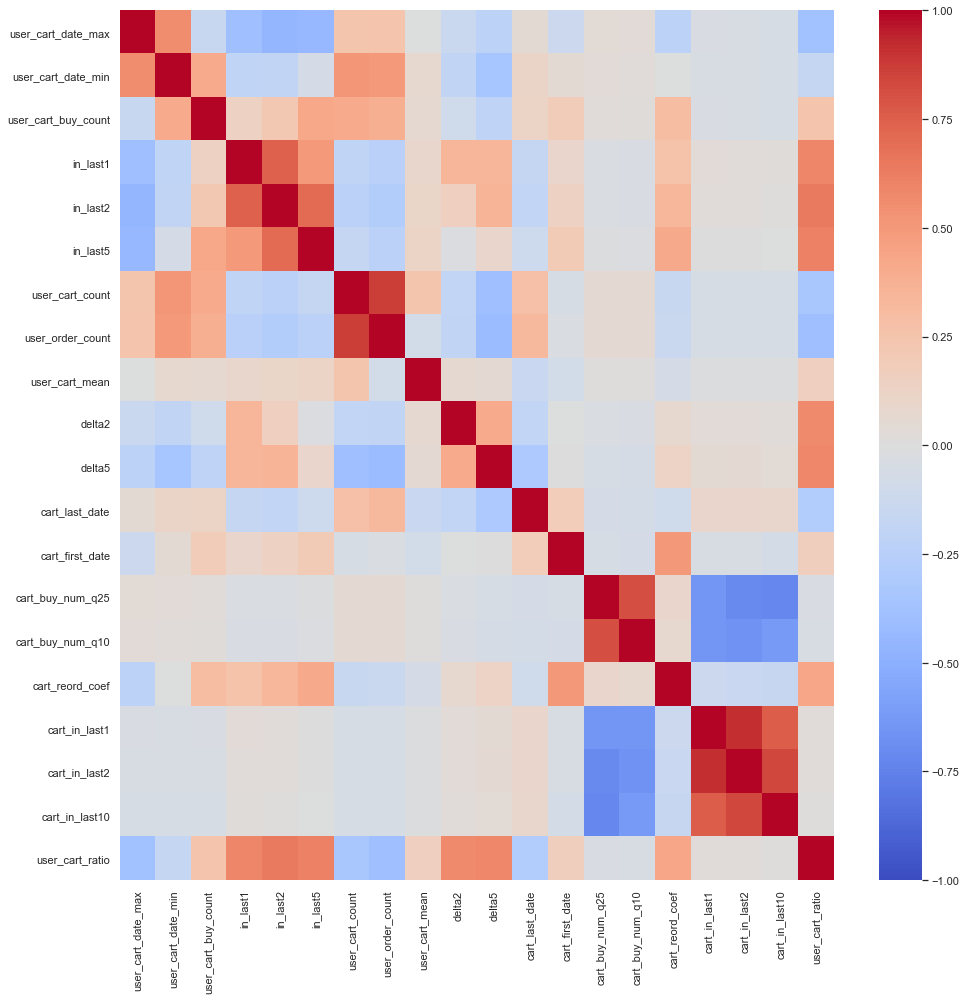

In [62]:
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(data_train[feat_smart2].corr(), annot = False, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm');

## Выбор модели
При обучении моделей можно использовать данные о покупках разной "глубины". Т.е. формировать признаки для одного, двух и т.д. последних заказах покупателя.

В финальной таблице указаны метрики моделей, обученных на третьей и четырех более ранних покупках (таргет - наличие во 2 и соотв. более ранних покупках). Валидация по прогнозу на признаках для 2 покупки и таргету (наличие в 1 покупке).

Результаты для другой "глубины" представлены в текстовых ячейках.

### Простой прогноз на основании последнего заказа
Самый простой вариант - предсказать по правилу был в последнем заказе - будет в следующем.

In [63]:
model_dict={} #словарь для данных по модели
b={}
b['model_name'] = 'Last1_dummy'
b['test_f1'] = f1_score(data_test['target'], data_test['in_last1'])
b['test_similar_f1'] = f1_score(data_test_similar['target'], data_test_similar['in_last1'])
model_dict[0] = b

final_table = pd.DataFrame(model_dict).T

In [64]:
final_table

,model_name,test_f1,test_similar_f1
0,Last1_dummy,0.40065,0.396803


In [65]:
sample_sub['user_id'] = sample_sub['user_id'].astype('int64')
sample_sub['cart'] = sample_sub['cart'].astype('int64')

last1_sub = sample_sub.merge(df_target, how='left', on=['user_id', 'cart']).fillna(0)
last1_sub['target'] = last1_sub['reverse_buy_num'].astype('int64')
last1_sub = last1_sub.loc[:, ['id', 'target']]
last1_sub = last1_sub.set_index(['id'])
last1_sub.to_csv('last1_sub.csv')
last1_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 790449 entries, 0;133 to 19998;415
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   target  790449 non-null  int64
dtypes: int64(1)
memory usage: 12.1+ MB


In [66]:
sample_sub['user_id'] = sample_sub['user_id'].astype('int64')
sample_sub['cart'] = sample_sub['cart'].astype('int64')

last1_sub = sample_sub.merge(df_target, how='left', on=['user_id', 'cart']).fillna(0)
last1_sub['target'] = last1_sub['reverse_buy_num'].astype('int64')
last1_sub = last1_sub.loc[:, ['id', 'target']]
last1_sub = last1_sub.set_index(['id'])
last1_sub.to_csv('last1_sub.csv')
last1_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 790449 entries, 0;133 to 19998;415
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   target  790449 non-null  int64
dtypes: int64(1)
memory usage: 12.1+ MB


### LogisticRegression

In [67]:
scaler = StandardScaler() #масштабируем признаки

model_dict={}   #словарь для данных по модели
i=0

for feat in feat_list:
    
    model = LogisticRegression(class_weight='balanced')
    b={}    
    b['model_name'] = 'LogisticRegression'
    b['feat_name'] = feat_name_list[i]
    
    # полный трейн / отфильтрованный тест 
    scaler.fit(data_train[feat])
    features_train = data_train[feat].copy()
    features_train = scaler.transform(features_train)
    target_train = data_train['target']
    features_test = data_test_similar[feat].copy() #data_test[feat].copy()
    features_test = scaler.transform(features_test)
    target_test = data_test_similar['target'] #data_test['target']
    
    model.fit(features_train, target_train)
    model_predicted = model.predict(features_test)
    b['test_f1'] = f1_score(target_test, model_predicted)
    
    # отфильтрованный трейн/тест (data_train_similar, data_test_similar)
    scaler.fit(data_train_similar[feat])
    features_train = data_train_similar[feat].copy()
    features_train = scaler.transform(features_train)
    target_train = data_train_similar['target']
    features_test = data_test_similar[feat].copy()
    features_test = scaler.transform(features_test)
    target_test = data_test_similar['target']
    
    model.fit(features_train, target_train)
    model_predicted = model.predict(features_test)
    b['test_similar_f1'] = f1_score(target_test, model_predicted)    
    
    model_dict[i] = b

    print('test f1:%.4f' %b['test_f1'], 'test_similar f1:%.4f' %b['test_similar_f1'], b['model_name'], b['feat_name'])
    i+=1
    
final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=False)

#'''

test f1:0.4895 test_similar f1:0.4854 LogisticRegression feat_smart2


In [68]:
final_table

,model_name,test_f1,test_similar_f1,feat_name
0,Last1_dummy,0.40065,0.396803,NaN
0,LogisticRegression,0.489533,0.485434,feat_smart2


#### Результаты LR (привести в порядок)

**на последней продаже**
* test f1:0.4802 valid f1:0.4833 LogisticRegression feat_full2
* test f1:**0.4829** valid f1:**0.4853** LogisticRegression **feat_smart**
* test f1:0.4777 valid f1:0.4811 LogisticRegression feat_20
* test f1:0.4808 valid f1:0.4847 LogisticRegression feat_10
* test f1:0.4804 valid f1:0.4832 LogisticRegression feat_1_2_5_10

колаб
* test f1:**0.4884** valid f1:0.4883 LogisticRegression feat_full2             лучший результат
* test f1:0.4882 valid f1:0.4891 LogisticRegression feat_smart                лучший результат
* test f1:0.4851 valid f1:0.4858 LogisticRegression feat_20
* test f1:0.4829 valid f1:0.4890 LogisticRegression feat_10
* test f1:0.4875 valid f1:0.4882 LogisticRegression feat_1_2_5_10

**на последней продаже с фильтром**  - хуже
колаб
* test f1:0.4829 valid f1:0.4779 LogisticRegression feat_full2
* test f1:0.4861 valid f1:0.4791 LogisticRegression feat_smart
* test f1:0.4816 valid f1:0.4754 LogisticRegression feat_20
* test f1:0.4822 valid f1:0.4799 LogisticRegression feat_10
* test f1:0.4828 valid f1:0.4778 LogisticRegression feat_1_2_5_10

**на 2 последних продажах**
* test f1:0.4804 valid f1:0.4832 LogisticRegression feat_1_2_5_10

**на 5 последних продажах**
*??? test f1:0.4961 valid f1:0.5039 LogisticRegression feat_full2
* test f1:0.4808 valid f1:0.4889 LogisticRegression feat_full2
* test f1:0.4855 valid f1:0.4897 LogisticRegression feat_smart
* test f1:0.4788 valid f1:0.4867 LogisticRegression feat_20
* test f1:0.4835 valid f1:0.4894 LogisticRegression feat_10
* test f1:0.4798 valid f1:0.4886 LogisticRegression feat_1_2_5_10

**на 5 последних продажах с фильтром**
* test f1:0.4734 valid f1:0.4786 LogisticRegression feat_full2
* test f1:0.4818 valid f1:0.4797 LogisticRegression feat_smart
* test f1:0.4730 valid f1:0.4763 LogisticRegression feat_20
* test f1:0.4832 valid f1:0.4804 LogisticRegression feat_10
* test f1:0.4731 valid f1:0.4783 LogisticRegression feat_1_2_5_10

In [71]:
'''
rcoef.nlargest(20).plot(kind='barh', figsize=(16, 6))
plt.title('LogisticRegression. Важность признаков', fontsize=20)
plt.ylabel('Признак', fontsize=16)
plt.xlabel('Важность', fontsize=16);
'''

"\nrcoef.nlargest(20).plot(kind='barh', figsize=(16, 6))\nplt.title('LogisticRegression. Важность признаков', fontsize=20)\nplt.ylabel('Признак', fontsize=16)\nplt.xlabel('Важность', fontsize=16);\n"

### LGBMClassifier

In [72]:
#обрезана выборка 
#data_train = data_train.sample(50000)

#### OPTUNA

In [73]:
# Подбор параметров optuna
'''
def objective(trial):

    features_train = data_train[feat].values
    features_test = data_test[feat].values
    target_train = data_train['target'].values.ravel()
    target_test = data_test['target'].values.ravel()

 #   train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
 #       'metric': 'f1_score',

        'objective': 'binary',
        'class_weight': 'balanced',  #is_unbalance=True
  #      'is_unbalance': 'True',
  #      'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
  #      'lambda_l1':
        'lambda_l2': trial.suggest_int('lambda_l2', 1, 12),
  #       categorical_feature=0,1,2означает, что столбец_0, столбец_1 и столбец_2 являются категориальными функциями
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 100),
  #      'n_estimators': trial.suggest_int('n_estimators', 11, 3611, 100)
  #      'max_depth': trial.suggest_int('max_depth', 10, 100)

    }
    
    
    
    model = LGBMClassifier(**param, cat_features=[0, 1])  
    
    model.fit(features_train,
              target_train,
              eval_set=(features_test, target_test),
              early_stopping_rounds=50,
              eval_metric='f1_score')                 #, cat_features=[0, 1]
    
    preds = model.predict(features_test)
    
    f1 = f1_score(target_test, preds)
    
    return f1


i=0
model_dict={}
print(feat_name_list)
print('cut_num:', cut_num)

for feat in feat_list:
    

    b={}
    b['model_name'] = 'LGBMClassifier'
    b['feat_name'] = feat_name_list[i]
    print('cut_num:', cut_num)
    print(b['feat_name'])

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)
    b['params'] =  study.best_params
    b['best_value'] = study.best_value
    print(b['best_value'], b['model_name'], b['feat_name'], 'cut_num:', cut_num)
    print(b['params'])
    model_dict[i] = b
    i+=1

    
final_table = pd.DataFrame(model_dict).T
final_table
'''

"\ndef objective(trial):\n\n    features_train = data_train[feat].values\n    features_test = data_test[feat].values\n    target_train = data_train['target'].values.ravel()\n    target_test = data_test['target'].values.ravel()\n\n #   train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)\n    param = {\n #       'metric': 'f1_score',\n\n        'objective': 'binary',\n        'class_weight': 'balanced',  #is_unbalance=True\n  #      'is_unbalance': 'True',\n  #      'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 12),\n        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),\n  #      'lambda_l1':\n        'lambda_l2': trial.suggest_int('lambda_l2', 1, 12),\n  #       categorical_feature=0,1,2означает, что столбец_0, столбец_1 и столбец_2 являются категориальными функциями\n        'num_leaves': trial.suggest_int('num_leaves', 10, 200),\n        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 1000),\

In [74]:
# Подбор параметров optuna
'''
def objective(trial):

    features_train = data_train[feat].values
    features_test = data_test[feat].values
    target_train = data_train['target'].values.ravel()
    target_test = data_test['target'].values.ravel()

 #   train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
 #       'metric': 'f1_score',

        'objective': 'binary',
        'class_weight': 'balanced',  #is_unbalance=True
  #      'is_unbalance': 'True',
  #      'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
  #      'lambda_l1':
        'lambda_l2': trial.suggest_int('lambda_l2', 1, 12),
  #       categorical_feature=0,1,2означает, что столбец_0, столбец_1 и столбец_2 являются категориальными функциями
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 100),
  #      'n_estimators': trial.suggest_int('n_estimators', 11, 3612, 100)
  #      'max_depth': trial.suggest_int('max_depth', 10, 100)

    }
    
    
    
    model = LGBMClassifier(**param)  
    
    model.fit(features_train,
              target_train,
              eval_set=(features_test, target_test),
              early_stopping_rounds=50,
              eval_metric='f1_score', cat_features=[0, 1], cat_features=[0, 1])                 #, cat_features=[0, 1]
    
    preds = model.predict(features_test)
    
    f1 = f1_score(target_test, preds)
    
    return f1


i=0
model_dict={}
print(feat_name_list)
print('cut_num:', cut_num)

for feat in feat_list:
    

    b={}
    b['model_name'] = 'LGBMClassifier'
    b['feat_name'] = feat_name_list[i]
    print('cut_num:', cut_num)
    print(b['feat_name'])

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)
    b['params'] =  study.best_params
    b['best_value'] = study.best_value
    print(b['best_value'], b['model_name'], b['feat_name'], 'cut_num:', cut_num)
    print(b['params'])
    model_dict[i] = b
    i+=1

    
final_table = pd.DataFrame(model_dict).T
final_table
'''

"\ndef objective(trial):\n\n    features_train = data_train[feat].values\n    features_test = data_test[feat].values\n    target_train = data_train['target'].values.ravel()\n    target_test = data_test['target'].values.ravel()\n\n #   train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)\n    param = {\n #       'metric': 'f1_score',\n\n        'objective': 'binary',\n        'class_weight': 'balanced',  #is_unbalance=True\n  #      'is_unbalance': 'True',\n  #      'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 12),\n        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),\n  #      'lambda_l1':\n        'lambda_l2': trial.suggest_int('lambda_l2', 1, 12),\n  #       categorical_feature=0,1,2означает, что столбец_0, столбец_1 и столбец_2 являются категориальными функциями\n        'num_leaves': trial.suggest_int('num_leaves', 10, 200),\n        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 1000),\

##### Результаты OPTUNA

**Для 1 последней покупки**

**feat_1_2_5_10**
Trial 18 finished with value: 0.4917236830447238 and parameters: {'learning_rate': 0.019393676658351948, 'min_child_samples': 96, 'num_leaves': 119, 'n_estimators': 2800, 'max_depth': 83}. Best is trial 18 with value: 0.4917236830447238.

**feat_full2**
Trial 12 finished with value: 0.49248313573976843 and parameters: {'learning_rate': 0.01079198008796116, 'min_child_samples': 97, 'num_leaves': 197, 'n_estimators': 2000, 'max_depth': 83}. Best is trial 12 with value: **0.49248313573976843**.
0.492652

Trial 13 finished with value: 0.49133175433599663 and parameters: {'learning_rate': 0.011670784555287117, 'num_leaves': 93, 'min_data_in_leaf': 307, 'min_child_samples': 100, 'n_estimators': 2900}. Best is trial 10 with value: 0.4918162781387614.

Trial 10 finished with value: 0.4918162781387614 and parameters: {'learning_rate': 0.010899146042896893, 'num_leaves': 100, 'min_data_in_leaf': 366, 'min_child_samples': 97, 'n_estimators': 3300}. Best is trial 10 with value: 0.4918162781387614.

Trial 19 finished with value: 0.49182094754704875 and parameters: {'learning_rate': 0.01737697428058406, 'num_leaves': 84, 'min_data_in_leaf': 203, 'min_child_samples': 74, 'n_estimators': 2700}. Best is trial 19 with value: 0.49182094754704875.

Trial 24 finished with value: 0.48410728756656635 and parameters: {'learning_rate': 0.0536830690377633, 'lambda_l2': 7, 'num_leaves': 166, 'min_data_in_leaf': 790, 'min_child_samples': 51, 'n_estimators': 2400}. Best is trial 24 with value: 0.48410728756656635.

Trial 10 finished with value: 0.4918162781387614 and parameters: {'learning_rate': 0.010899146042896893, 'num_leaves': 100, 'min_data_in_leaf': 366, 'min_child_samples': 97, 'n_estimators': 3300}. Best is trial 10

Trial 19 finished with value: 0.49182094754704875 and parameters: {'learning_rate': 0.01737697428058406, 'num_leaves': 84, 'min_data_in_leaf': 203, 'min_child_samples': 74, 'n_estimators': 2700}. Best is trial 19 with value: 0.49182094754704875.

Trial 3 finished with value: 0.4921131769667129 and parameters: {'learning_rate': 0.0738773325460906, 'lambda_l2': 6, 'num_leaves': 197, 'min_data_in_leaf': 510, 'min_child_samples': 75}. Best is trial 3 with value: 0.4921131769667129.

**feat_smart**
Trial 14 finished with value: 0.49237447636404874 and parameters: {'learning_rate': 0.06775158111498988, 'lambda_l2': 9, 'num_leaves': 158, 'min_data_in_leaf': 992, 'min_child_samples': 23}. Best is trial 14 with value: 0.49237447636404874.

**Для 5 покупок**

Trial 16 finished with value: 0.48841617102161944 and parameters: {'learning_rate': 0.02874349564383257, 'num_leaves': 62, 'min_data_in_leaf': 332, 'min_child_samples': 23, 'n_estimators': 2400}. Best is trial 7 with value: 0.48968664368016274.

Trial 7 finished with value: 0.48968664368016274 and parameters: {'learning_rate': 0.018263083667196867, 'num_leaves': 163, 'min_data_in_leaf': 577, 'min_child_samples': 16, 'n_estimators': 3500}. Best is trial 7 with value: 0.48968664368016274.

Trial 2 finished with value: 0.5045384932649974 and parameters: {'learning_rate': 0.06363833577122488, 'lambda_l2': 5, 'num_leaves': 31, 'min_data_in_leaf': 520, 'min_child_samples': 54, 'n_estimators': 2700}. Best is trial 2 with value: **0.5045384932649974**.

Trial 13 finished with value: 0.5045911730582998 and parameters: {'learning_rate': 0.0651508111576026, 'lambda_l2': 6, 'num_leaves': 48, 'min_data_in_leaf': 304, 'min_child_samples': 100, 'n_estimators': 1700}. Best is trial 13 with value: **0.5045911730582998**.

Trial 28 finished with value: 0.5045069199734437 and parameters: {'learning_rate': 0.04006958730220429, 'lambda_l2': 6, 'num_leaves': 38, 'min_data_in_leaf': 582, 'min_child_samples': 38, 'n_estimators': 1800}. Best is trial 13 with value: **0.5045911730582998**.

Trial 29 finished with value: 0.5047614786788015 and parameters: {'learning_rate': 0.02394039982940155, 'lambda_l2': 5, 'num_leaves': 50, 'min_data_in_leaf': 825, 'min_child_samples': 93, 'n_estimators': 2200}. Best is trial 29 with value: **0.5047614786788015**.

Trial 10 finished with value: 0.4877095828635852 and parameters: {'learning_rate': 0.09675936880230837, 'lambda_l2': 8, 'num_leaves': 133, 'min_data_in_leaf': 288, 'min_child_samples': 11}. Best is trial 10 with value: 0.4877095828635852.

Trial 28 finished with value: 0.48880292974054873 and parameters: {'learning_rate': 0.09046294430319603, 'lambda_l2': 10, 'num_leaves': 168, 'min_data_in_leaf': 905, 'min_child_samples': 35}. Best is trial 28 with value: 0.48880292974054873.

Trial 11 finished with value: 0.48775637222080076 and parameters: {'learning_rate': 0.011116812488876238, 'lambda_l2': 10, 'num_leaves': 95, 'min_data_in_leaf': 440, 'min_child_samples': 100, 'n_estimators': 3311}. Best is trial 11 with value: 0.48775637222080076.

#### Тест LGBM

In [75]:
#Подбор параметров gridSearchCV
'''
model_dict={}   #словарь для данных по модели
i=0
for feat in feat_list:

    features_train = data_train[feat].copy()
    features_test = data_test[feat].copy()
    target_train = data_train['target']
    target_test = data_test['target']
    
    
    model = LGBMClassifier(class_weight='balanced')
    b={}
    b['model_name'] = 'LGBMClassifier'
    b['feat_name'] = feat_name_list[i]
    
    parametrs = { 'class_weight': ['balanced'],
                  #'min_child_samples': [40, 45],
                  #'num_leaves': [98], #до того лучший - 101
                  'learning_rate': [0.01], 
                  'min_child_samples': [97], 
                  'num_leaves': [197], 
                  'n_estimators': [2000], 
                  'max_depth': [83]}
    
    grid = GridSearchCV(model, parametrs, cv=kfold, scoring='f1') #, iid=True
    grid.fit(features_train.values, target_train.values.ravel())
    b['params'] = grid.best_params_
    model = LGBMClassifier().set_params(**b['params'])
#    b['model_valid_f1'] = cross_val_score(
#        model, features_train.values, target_train.values.ravel(), cv=kfold, scoring='f1').mean()

    model.fit(features_train.values, target_train.values.ravel())
    
    model_predicted = model.predict(features_test.values)
    
    b['model_test_f1'] = f1_score(target_test.values.ravel(), model_predicted)
    model_dict[i] = b

    # сохраним важность признаков        
    if feat == feat_1_2_5_10:
        lgbm_feat_importances = pd.Series(
            model.feature_importances_, index=feat)/model.feature_importances_.sum()      

    print('test f1:%.4f' %b['model_test_f1'], b['model_name'], b['feat_name']) #'valid f1:%.4f' %b['model_valid_f1']
    print(b['params'])
    i+=1

final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=False)
final_table
'''

"\nmodel_dict={}   #словарь для данных по модели\ni=0\nfor feat in feat_list:\n\n    features_train = data_train[feat].copy()\n    features_test = data_test[feat].copy()\n    target_train = data_train['target']\n    target_test = data_test['target']\n    \n    \n    model = LGBMClassifier(class_weight='balanced')\n    b={}\n    b['model_name'] = 'LGBMClassifier'\n    b['feat_name'] = feat_name_list[i]\n    \n    parametrs = { 'class_weight': ['balanced'],\n                  #'min_child_samples': [40, 45],\n                  #'num_leaves': [98], #до того лучший - 101\n                  'learning_rate': [0.01], \n                  'min_child_samples': [97], \n                  'num_leaves': [197], \n                  'n_estimators': [2000], \n                  'max_depth': [83]}\n    \n    grid = GridSearchCV(model, parametrs, cv=kfold, scoring='f1') #, iid=True\n    grid.fit(features_train.values, target_train.values.ravel())\n    b['params'] = grid.best_params_\n    model = LGBMClassif

In [76]:
'''Для теста 1

print(feat_name_list)
print('cut_num:', cut_num)

model_dict={}   #словарь для данных по модели
i=0
for feat in feat_list:

    features_train = data_train[feat].copy()
    features_test = data_test[feat].copy()
    target_train = data_train['target']
    target_test = data_test['target']
    
    
    model = LGBMClassifier(class_weight='balanced')
    b={}
    b['model_name'] = 'LGBMClassifier'
    b['feat_name'] = feat_name_list[i]
    
 
    model = LGBMClassifier(class_weight='balanced',
                  objective='binary',
                  learning_rate=0.0651508111576026,
                  lambda_l2=6,
                  min_child_samples=100, 
                  num_leaves=48, 
                  min_data_in_leaf=304,
                  n_estimators=1700)
#    b['model_valid_f1'] = cross_val_score(
#        model, features_train.values, target_train.values.ravel(), cv=kfold, scoring='f1').mean()

    model.fit(features_train.values, target_train.values.ravel())
    
    model_predicted = model.predict(features_test.values)
    
    b['model_test_f1'] = f1_score(target_test.values.ravel(), model_predicted)
    model_dict[i] = b

    print('test f1:%.4f' %b['model_test_f1'], b['model_name'], b['feat_name']) #'valid f1:%.4f' %b['model_valid_f1']
    i+=1

final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=False)
final_table

cm = confusion_matrix(target_test.values.ravel(), model_predicted)
tn, fp, fn, tp = cm.ravel()
print(cm)
print(tn)
print(fn)
print(tp)
print(fp)
'''

"Для теста 1\n\nprint(feat_name_list)\nprint('cut_num:', cut_num)\n\nmodel_dict={}   #словарь для данных по модели\ni=0\nfor feat in feat_list:\n\n    features_train = data_train[feat].copy()\n    features_test = data_test[feat].copy()\n    target_train = data_train['target']\n    target_test = data_test['target']\n    \n    \n    model = LGBMClassifier(class_weight='balanced')\n    b={}\n    b['model_name'] = 'LGBMClassifier'\n    b['feat_name'] = feat_name_list[i]\n    \n \n    model = LGBMClassifier(class_weight='balanced',\n                  objective='binary',\n                  learning_rate=0.0651508111576026,\n                  lambda_l2=6,\n                  min_child_samples=100, \n                  num_leaves=48, \n                  min_data_in_leaf=304,\n                  n_estimators=1700)\n#    b['model_valid_f1'] = cross_val_score(\n#        model, features_train.values, target_train.values.ravel(), cv=kfold, scoring='f1').mean()\n\n    model.fit(features_train.values, t

In [77]:
'''Для теста 2

print(feat_name_list)
print('cut_num:', cut_num) 

model_dict={}   #словарь для данных по модели
i=0
for feat in feat_list:

    features_train = data_train[feat].copy()
    features_test = data_test[feat].copy()
    target_train = data_train['target']
    target_test = data_test['target']
    
    
    model = LGBMClassifier(class_weight='balanced')
    b={}
    b['model_name'] = 'LGBMClassifier'
    b['feat_name'] = feat_name_list[i]
    
 
    model = LGBMClassifier(class_weight='balanced',
                           objective='binary', 
                           learning_rate=0.0738773325460906, 
                           lambda_l2=6, 
                           num_leaves=197, 
                           min_data_in_leaf=510, 
                           min_child_samples=75)
#    b['model_valid_f1'] = cross_val_score(
#        model, features_train.values, target_train.values.ravel(), cv=kfold, scoring='f1').mean()

    model.fit(features_train.values, target_train.values.ravel())
    
    model_predicted = model.predict(features_test.values)
    
    b['model_test_f1'] = f1_score(target_test.values.ravel(), model_predicted)
    model_dict[i] = b

    print('test f1:%.4f' %b['model_test_f1'], b['model_name'], b['feat_name']) #'valid f1:%.4f' %b['model_valid_f1']
    i+=1

final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=False)
final_table

cm = confusion_matrix(target_test.values.ravel(), model_predicted)
tn, fp, fn, tp = cm.ravel()
print(cm)
print(tn)
print(fn)
print(tp)
print(fp)
'''

"Для теста 2\n\nprint(feat_name_list)\nprint('cut_num:', cut_num) \n\nmodel_dict={}   #словарь для данных по модели\ni=0\nfor feat in feat_list:\n\n    features_train = data_train[feat].copy()\n    features_test = data_test[feat].copy()\n    target_train = data_train['target']\n    target_test = data_test['target']\n    \n    \n    model = LGBMClassifier(class_weight='balanced')\n    b={}\n    b['model_name'] = 'LGBMClassifier'\n    b['feat_name'] = feat_name_list[i]\n    \n \n    model = LGBMClassifier(class_weight='balanced',\n                           objective='binary', \n                           learning_rate=0.0738773325460906, \n                           lambda_l2=6, \n                           num_leaves=197, \n                           min_data_in_leaf=510, \n                           min_child_samples=75)\n#    b['model_valid_f1'] = cross_val_score(\n#        model, features_train.values, target_train.values.ravel(), cv=kfold, scoring='f1').mean()\n\n    model.fit(feat

In [78]:
'''Для теста 3

print(feat_name_list)
print('cut_num:', cut_num)

model_dict={}   #словарь для данных по модели
i=0
for feat in feat_list:

    features_train = data_train[feat].copy()
    features_test = data_test[feat].copy()
    target_train = data_train['target']
    target_test = data_test['target']
    
    
    model = LGBMClassifier(class_weight='balanced')
    b={}
    b['model_name'] = 'LGBMClassifier'
    b['feat_name'] = feat_name_list[i]
    
 
    model = LGBMClassifier(class_weight='balanced',
                           objective='binary',learning_rate=0.01079198008796116,
                           min_child_samples=97, 
                           num_leaves=197, 
                           n_estimators=2000, 
                           max_depth=83)
#    b['model_valid_f1'] = cross_val_score(
#        model, features_train.values, target_train.values.ravel(), cv=kfold, scoring='f1').mean()

    model.fit(features_train.values, target_train.values.ravel())
    
    model_predicted = model.predict(features_test.values)
    
    b['model_test_f1'] = f1_score(target_test.values.ravel(), model_predicted)
    model_dict[i] = b

    print('test f1:%.4f' %b['model_test_f1'], b['model_name'], b['feat_name']) #'valid f1:%.4f' %b['model_valid_f1']
    i+=1

final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=False)
final_table

cm = confusion_matrix(target_test.values.ravel(), model_predicted)
tn, fp, fn, tp = cm.ravel()
print(cm)
print(tn)
print(fn)
print(tp)
print(fp)
'''

"Для теста 3\n\nprint(feat_name_list)\nprint('cut_num:', cut_num)\n\nmodel_dict={}   #словарь для данных по модели\ni=0\nfor feat in feat_list:\n\n    features_train = data_train[feat].copy()\n    features_test = data_test[feat].copy()\n    target_train = data_train['target']\n    target_test = data_test['target']\n    \n    \n    model = LGBMClassifier(class_weight='balanced')\n    b={}\n    b['model_name'] = 'LGBMClassifier'\n    b['feat_name'] = feat_name_list[i]\n    \n \n    model = LGBMClassifier(class_weight='balanced',\n                           objective='binary',learning_rate=0.01079198008796116,\n                           min_child_samples=97, \n                           num_leaves=197, \n                           n_estimators=2000, \n                           max_depth=83)\n#    b['model_valid_f1'] = cross_val_score(\n#        model, features_train.values, target_train.values.ravel(), cv=kfold, scoring='f1').mean()\n\n    model.fit(features_train.values, target_train.v

In [79]:
'''Для теста 4

print(feat_name_list)
print('cut_num:', cut_num)

model_dict={}   #словарь для данных по модели
i=0
for feat in feat_list:

    features_train = data_train[feat].copy()
    features_test = data_test[feat].copy()
    target_train = data_train['target']
    target_test = data_test['target']
    
    
    model = LGBMClassifier(class_weight='balanced')
    b={}
    b['model_name'] = 'LGBMClassifier'
    b['feat_name'] = feat_name_list[i]
    
 
    model = LGBMClassifier(class_weight='balanced',
                           objective='binary',
                           learning_rate=0.06775158111498988, 
                           lambda_l2=9, 
                           num_leaves=158, 
                           min_data_in_leaf=992, 
                           min_child_samples=23)
#    b['model_valid_f1'] = cross_val_score(
#        model, features_train.values, target_train.values.ravel(), cv=kfold, scoring='f1').mean()

    model.fit(features_train.values, target_train.values.ravel())
    
    model_predicted = model.predict(features_test.values)
    
    b['model_test_f1'] = f1_score(target_test.values.ravel(), model_predicted)
    model_dict[i] = b

    print('test f1:%.4f' %b['model_test_f1'], b['model_name'], b['feat_name']) #'valid f1:%.4f' %b['model_valid_f1']
    i+=1

final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=False)
final_table

cm = confusion_matrix(target_test.values.ravel(), model_predicted)
tn, fp, fn, tp = cm.ravel()
print(cm)
print(tn)
print(fn)
print(tp)
print(fp)
'''

"Для теста 4\n\nprint(feat_name_list)\nprint('cut_num:', cut_num)\n\nmodel_dict={}   #словарь для данных по модели\ni=0\nfor feat in feat_list:\n\n    features_train = data_train[feat].copy()\n    features_test = data_test[feat].copy()\n    target_train = data_train['target']\n    target_test = data_test['target']\n    \n    \n    model = LGBMClassifier(class_weight='balanced')\n    b={}\n    b['model_name'] = 'LGBMClassifier'\n    b['feat_name'] = feat_name_list[i]\n    \n \n    model = LGBMClassifier(class_weight='balanced',\n                           objective='binary',\n                           learning_rate=0.06775158111498988, \n                           lambda_l2=9, \n                           num_leaves=158, \n                           min_data_in_leaf=992, \n                           min_child_samples=23)\n#    b['model_valid_f1'] = cross_val_score(\n#        model, features_train.values, target_train.values.ravel(), cv=kfold, scoring='f1').mean()\n\n    model.fit(featu

### вероятность класса 1


fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:, 1])  
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

In [80]:
'''Для теста 00
#необрезанный трейн


print(feat_name_list)
print('cut_num:', cut_num)

model_dict={}   #словарь для данных по модели
i=0
for feat in feat_list:

#   data_train_CORR = data_train[data_train['delta2']<=90] #только покупатели с последним заказом не раньше 90 дней
#    print(len(data_train.index))
 # data_train_CORR = data_train[data_train['user_order_count']>1] #только покупатели с 2 и более заказами
    data_train_CORR = data_train.copy()
#    print(len(data_train.index))
    data_test_CORR = data_test[data_test['user_order_count']>2]
    
    features_train = data_train_CORR[feat].copy()
    features_test = data_test_CORR[feat].copy()
    target_train = data_train_CORR['target']
    target_test = data_test_CORR['target']
    
    
    model = LGBMClassifier(class_weight='balanced')
    b={}
    b['model_name'] = 'LGBMClassifier'
    b['feat_name'] = feat_name_list[i]
    
 
    model = LGBMClassifier(class_weight='balanced',
                           objective='binary',learning_rate=0.01079198008796116,
                           min_child_samples=97, 
                           num_leaves=197, 
                           n_estimators=2000, 
                           max_depth=83)
#    b['model_valid_f1'] = cross_val_score(
#        model, features_train.values, target_train.values.ravel(), cv=kfold, scoring='f1').mean()

    model.fit(features_train.values, target_train.values.ravel())
    
    model_predicted = model.predict(features_test.values)
    model_proba = model.predict_proba(features_test.values)
    
    b['model_test_f1'] = f1_score(target_test.values.ravel(), model_predicted)
    model_dict[i] = b

    print('test f1:%.4f' %b['model_test_f1'], b['model_name'], b['feat_name']) #'valid f1:%.4f' %b['model_valid_f1']
    i+=1

final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=False)
final_table

cm = confusion_matrix(target_test.values.ravel(), model_predicted)
tn, fp, fn, tp = cm.ravel()
print(cm)
'''

#предсказанное количество заказов
#print('предсказано заказов:', model_predicted.sum())

#количество заказов в test
#print('реально заказов:', target_test.sum())

"Для теста 00\n#необрезанный трейн\n\n\nprint(feat_name_list)\nprint('cut_num:', cut_num)\n\nmodel_dict={}   #словарь для данных по модели\ni=0\nfor feat in feat_list:\n\n#   data_train_CORR = data_train[data_train['delta2']<=90] #только покупатели с последним заказом не раньше 90 дней\n#    print(len(data_train.index))\n # data_train_CORR = data_train[data_train['user_order_count']>1] #только покупатели с 2 и более заказами\n    data_train_CORR = data_train.copy()\n#    print(len(data_train.index))\n    data_test_CORR = data_test[data_test['user_order_count']>2]\n    \n    features_train = data_train_CORR[feat].copy()\n    features_test = data_test_CORR[feat].copy()\n    target_train = data_train_CORR['target']\n    target_test = data_test_CORR['target']\n    \n    \n    model = LGBMClassifier(class_weight='balanced')\n    b={}\n    b['model_name'] = 'LGBMClassifier'\n    b['feat_name'] = feat_name_list[i]\n    \n \n    model = LGBMClassifier(class_weight='balanced',\n                

In [81]:
#необрезанный
'''
proba_df = pd.DataFrame()
proba_df['pred'] = model_predicted
proba_df['probab_0'] = model_proba[:, 0]
proba_df['probab_1'] = model_proba[:, 1]
proba_df['correct_pred'] = proba_df['probab_1']>0.5444
proba_df.head(30)
f1_score(target_test.values.ravel(), proba_df['correct_pred'].values)
'''

"\nproba_df = pd.DataFrame()\nproba_df['pred'] = model_predicted\nproba_df['probab_0'] = model_proba[:, 0]\nproba_df['probab_1'] = model_proba[:, 1]\nproba_df['correct_pred'] = proba_df['probab_1']>0.5444\nproba_df.head(30)\nf1_score(target_test.values.ravel(), proba_df['correct_pred'].values)\n"

In [82]:
'''Для теста 00
#обрезанный трейн (>2)


print(feat_name_list)
print('cut_num:', cut_num)

model_dict={}   #словарь для данных по модели
i=0
for feat in feat_list:

#   data_train_CORR = data_train[data_train['delta2']<=90] #только покупатели с последним заказом не раньше 90 дней
#    print(len(data_train.index))
    data_train_CORR = data_train[data_train['user_order_count']>2] #только покупатели с 2 и более заказами
   # data_train_CORR = data_train.copy()
#    print(len(data_train.index))
    data_test_CORR = data_test[data_test['user_order_count']>2]
    
    features_train = data_train_CORR[feat].copy()
    features_test = data_test_CORR[feat].copy()
    target_train = data_train_CORR['target']
    target_test = data_test_CORR['target']
    
    
    model = LGBMClassifier(class_weight='balanced')
    b={}
    b['model_name'] = 'LGBMClassifier'
    b['feat_name'] = feat_name_list[i]
    
 
    model = LGBMClassifier(class_weight='balanced',
                           objective='binary',learning_rate=0.01079198008796116,
                           min_child_samples=97, 
                           num_leaves=197, 
                           n_estimators=2000, 
                           max_depth=83)
#    b['model_valid_f1'] = cross_val_score(
#        model, features_train.values, target_train.values.ravel(), cv=kfold, scoring='f1').mean()

    model.fit(features_train.values, target_train.values.ravel())
    
    model_predicted2 = model.predict(features_test.values)
    model_proba2 = model.predict_proba(features_test.values)
    
    b['model_test_f1'] = f1_score(target_test.values.ravel(), model_predicted)
    model_dict[i] = b

    print('test f1:%.4f' %b['model_test_f1'], b['model_name'], b['feat_name']) #'valid f1:%.4f' %b['model_valid_f1']
    i+=1

final_table = pd.DataFrame(model_dict).T
final_table

cm = confusion_matrix(target_test.values.ravel(), model_predicted2)
tn, fp, fn, tp = cm.ravel()
print(cm)
'''

"Для теста 00\n#обрезанный трейн (>2)\n\n\nprint(feat_name_list)\nprint('cut_num:', cut_num)\n\nmodel_dict={}   #словарь для данных по модели\ni=0\nfor feat in feat_list:\n\n#   data_train_CORR = data_train[data_train['delta2']<=90] #только покупатели с последним заказом не раньше 90 дней\n#    print(len(data_train.index))\n    data_train_CORR = data_train[data_train['user_order_count']>2] #только покупатели с 2 и более заказами\n   # data_train_CORR = data_train.copy()\n#    print(len(data_train.index))\n    data_test_CORR = data_test[data_test['user_order_count']>2]\n    \n    features_train = data_train_CORR[feat].copy()\n    features_test = data_test_CORR[feat].copy()\n    target_train = data_train_CORR['target']\n    target_test = data_test_CORR['target']\n    \n    \n    model = LGBMClassifier(class_weight='balanced')\n    b={}\n    b['model_name'] = 'LGBMClassifier'\n    b['feat_name'] = feat_name_list[i]\n    \n \n    model = LGBMClassifier(class_weight='balanced',\n           

In [83]:
#предсказанное количество заказов
#print('предсказано заказов:', model_predicted2.sum())

#количество заказов в test
#print('реально заказов:', target_test.sum())

In [84]:
#обрезанный
'''
proba_df = pd.DataFrame()
proba_df['pred'] = model_predicted2
proba_df['probab_0'] = model_proba2[:, 0]
proba_df['probab_1'] = model_proba2[:, 1]
proba_df['correct_pred'] = proba_df['probab_1']>0.5734
proba_df.head(30)
f1_score(target_test.values.ravel(), proba_df['correct_pred'].values)
'''

"\nproba_df = pd.DataFrame()\nproba_df['pred'] = model_predicted2\nproba_df['probab_0'] = model_proba2[:, 0]\nproba_df['probab_1'] = model_proba2[:, 1]\nproba_df['correct_pred'] = proba_df['probab_1']>0.5734\nproba_df.head(30)\nf1_score(target_test.values.ravel(), proba_df['correct_pred'].values)\n"

#### Результаты определения порога класса
**на полном трейне**
['feat_smart2']
cut_num: 2
test f1:0.4929 LGBMClassifier feat_smart2
[[651546 184968]
 [ 70549 124196]]
proba_df['correct_pred'] = proba_df['probab_1']>0.535
test f1: 0.4944

**на урезанном ('user_order_count']>2) трейне**
cut_num: 2
test f1:0.4905 LGBMClassifier feat_smart2
[[641466 195048]
 [ 68070 126675]]
proba_df['correct_pred'] = proba_df['probab_1']>0.542
test f1: 0.4939

**на полном и 2 последних продажах**
['feat_smart2']
cut_num: 3
test f1:0.4913 LGBMClassifier feat_smart2
[[643550 192964]
 [ 68481 126264]]
proba_df['correct_pred'] = proba_df['probab_1']>0.541
test f1: 0,4943
    
**на урезанном ('user_order_count']>2) и 2 последних продажах**
cut_num: 3
test f1:0.4900 LGBMClassifier feat_smart2
[[630982 205532]
 [ 64869 129876]]
proba_df['correct_pred'] = proba_df['probab_1']>0.559
test f1: 0.4951486169226637
    
**на полном и 5 последних продажах**!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
 ['feat_smart2']
cut_num: 6
test f1:0.4902 LGBMClassifier feat_smart2
[[626485 210029]
 [ 63338 131407]]
proba_df['correct_pred'] = proba_df['probab_1']>0.558
test f1: 0.49602192551672086

**на урезанном ('user_order_count']>2) и 5 последних продажах**
cut_num: 6
test f1:0.4902 LGBMClassifier feat_smart2
[[617495 219019]
 [ 61096 133649]]
proba_df['correct_pred'] = proba_df['probab_1']>0.56
test f1: 0.495975
    
**на полном и 10 последних продажах**                **тест обычный**
['feat_smart2']
cut_num: 11
test f1:0.4899 LGBMClassifier feat_smart2
[[623835 212679]
 [ 62569 132176]]
proba_df['correct_pred'] = proba_df['probab_1']>0.556
test f1:0.4956944391289371
    
**на урезанном ('user_order_count']>2) и 10 последних продажах**                **тест обычный**
['feat_smart2']
cut_num: 11
test f1:0.4899 LGBMClassifier feat_smart2
[[611224 225290]
 [ 59532 135213]]
proba_df['correct_pred'] = proba_df['probab_1']>0.5595
test f1: 0.49602574710355446
    
**на полном трейне и 10 последних продажах**                **тест урезанный ('user_order_count']>2)**
cut_num: 11
test f1:0.4898 LGBMClassifier feat_smart2
[[593041 176148]
 [ 58219 112484]]
proba_df['correct_pred'] = proba_df['probab_1']>0.5444
test f1: 0.49491261947268067
    
**на урезанном трейне ('user_order_count']>2) трейне и 10 последних продажах** **тест урезанный ('user_order_count']>2)**
cut_num: 11
test f1:0.4898 LGBMClassifier feat_smart2
[[574597 194592]
 [ 53746 116957]]
proba_df['correct_pred'] = proba_df['probab_1']>0.5734
test f1: 0.49468128661500554

In [85]:
'''Для теста 0
model_dict={}   #словарь для данных по модели
i=0

for rs in [2, 3, 4, 35, 45, 67, 84, 91, 123, 2]:
    data_train_RS = data_train.sample(n = 50000, random_state = rs)
    print(rs)


    features_train = data_train[feat_1_2_5_10].copy()
    features_test = data_test[feat_1_2_5_10].copy()
    target_train = data_train['target']
    target_test = data_test['target']
    
    
    model = LGBMClassifier(class_weight='balanced', learning_rate=0.02, max_depth=14, n_estimators=2000)
    b={}
    b['model_name'] = 'LGBMClassifier'

    
 
    model = LGBMClassifier(class_weight='balanced', learning_rate=0.02, max_depth=14, n_estimators=2000)
#    b['model_valid_f1'] = cross_val_score(
#        model, features_train.values, target_train.values.ravel(), cv=kfold, scoring='f1').mean()

    model.fit(features_train.values, target_train.values.ravel())
    
    model_predicted = model.predict(features_test.values)
    
    b['model_test_f1'] = f1_score(target_test.values.ravel(), model_predicted)
    model_dict[i] = b

    print('test f1:%.4f' %b['model_test_f1'], b['model_name']) #'valid f1:%.4f' %b['model_valid_f1']


final_table = pd.DataFrame(model_dict).T
final_table

cm = confusion_matrix(target_test.values.ravel(), model_predicted)
tn, fp, fn, tp = cm.ravel()
print(cm)
print(tn)
print(fn)
print(tp)
print(fp)
'''

"Для теста 0\nmodel_dict={}   #словарь для данных по модели\ni=0\n\nfor rs in [2, 3, 4, 35, 45, 67, 84, 91, 123, 2]:\n    data_train_RS = data_train.sample(n = 50000, random_state = rs)\n    print(rs)\n\n\n    features_train = data_train[feat_1_2_5_10].copy()\n    features_test = data_test[feat_1_2_5_10].copy()\n    target_train = data_train['target']\n    target_test = data_test['target']\n    \n    \n    model = LGBMClassifier(class_weight='balanced', learning_rate=0.02, max_depth=14, n_estimators=2000)\n    b={}\n    b['model_name'] = 'LGBMClassifier'\n\n    \n \n    model = LGBMClassifier(class_weight='balanced', learning_rate=0.02, max_depth=14, n_estimators=2000)\n#    b['model_valid_f1'] = cross_val_score(\n#        model, features_train.values, target_train.values.ravel(), cv=kfold, scoring='f1').mean()\n\n    model.fit(features_train.values, target_train.values.ravel())\n    \n    model_predicted = model.predict(features_test.values)\n    \n    b['model_test_f1'] = f1_score(ta

0-1
23  	0.509557
{'learning_rate': 0.06577953140046877, 'min_child_samples': 79, 'num_leaves': 167, 'n_estimators': 2269, 'max_depth': 72}
    
0-2     0.5046058672852931
Best is trial 39 with value: 0.5046058672852931.
{'learning_rate': 0.09056947244546623, 'min_child_samples': 88, 'num_leaves': 173, 'n_estimators': 1862, 'max_depth': 25}

0-3      0.5051490300434279 
{'learning_rate': 0.09871540359285974, 'min_child_samples': 61, 'num_leaves': 194, 'n_estimators': 2875, 'max_depth': 85}

**Параметры 0-3**

{'learning_rate': 0.09871540359285974,
 'min_child_samples': 61,
 'num_leaves': 194,
 'n_estimators': 2875,
 'max_depth': 85}

##### Результаты теста (обучение на ранних валидация на предпоследней)

**Старые результаты**
test f1:0.4830 valid f1:0.4856 LGBMClassifier feat_1_2_5_10
{'class_weight': 'balanced', 'max_depth': 37, 'n_estimators': 198}

test f1:0.4523 valid f1:0.4396 LGBMClassifier feat_1_2_5_10
{'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 2000}

test f1:0.4861 valid f1:0.4879 LGBMClassifier feat_1_2_5_10
{'class_weight': 'balanced', 'learning_rate': 0.011258684951755554, 'max_depth': 42, 'min_child_samples': 64, 'n_estimators': 2059, 'num_leaves': 41}


**Новые результаты**
feat_full2
{'learning_rate': 0.01079198008796116, 'min_child_samples': 97, 'num_leaves': 197, 'n_estimators': 2000, 'max_depth': 83}
весь тест

1 предпоследняя продажа  
0.492652 параметры  см. выше  
0.484438  то-же и n_estimators=10000  
0.490753 (learning_rate=0.02, n_estimators=2000, max_depth=15)

1 предпоследняя продажа и условия (<90 дней и >=2)  
0.485313 параметры  см. выше 
0.477653 то-же и n_estimators=10000  
0.484182 (learning_rate=0.02, n_estimators=2000, max_depth=15)


2 предпоследние продажи  
0.491132

2 предпоследние продажи и условия (<90 дней и >=2)  
0.482188

5 предпоследних продаж  
0.489864

5 предпоследних продаж и условия (<90 дней и >=2)  
0.481659

    parametrs = { 'class_weight': ['balanced'],
                  'learning_rate': [0.02, 0.01],
                  'n_estimators': [500, 1000, 2000, 3000],
                  'max_depth': [5, 7, 10, 14]}

№ |model_name | feat_name | params | model_valid_f1 | model_test_f1
 ---: | ---: | :--- | :--- | :--- | :---
0 |	LGBMClassifier |	feat_full2 | 'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 2000 |	0.492603 | 0.485135
1 | LGBMClassifier |	feat_20 |	'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 3000 |	0.491637 |	0.485087
2 |	LGBMClassifier |	feat_10 |	'learning_rate': 0.02, 'max_depth': 7, 'n_estimators': 1000 |	0.488315 |	0.481001
3 |	LGBMClassifier |	**feat_1_2_5_10** | 'learning_rate': 0.02, 'max_depth': 14, 'n_estimators': 2000 | **0.49286** |	**0.485343**
4 |	LGBMClassifier |	feat_1_10 |	'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 3000 |	0.491352 |	0.485332

    parametrs = { 'class_weight': ['balanced'],
                  'min_child_samples': [15, 20, 25],
                  'num_leaves': [31, 41, 51],
                  'learning_rate': [0.02],
                  'n_estimators': [1500, 2000, 2500], #, 1000, 2000, 3000
                  'max_depth': [6, 9, 12, 15]}

test f1:0.4882 valid f1:0.4836 LGBMClassifier feat_full2
{'max_depth': 15, 'min_child_samples': 15, 'n_estimators': 1500, 'num_leaves': 41}
test f1:0.4862 valid f1:0.4828 LGBMClassifier feat_20
{'max_depth': 15, 'min_child_samples': 25, 'n_estimators': 2000, 'num_leaves': 51}
test f1:0.4873 valid f1:0.4838 LGBMClassifier feat_1_2_5_10
{'max_depth': 12, 'min_child_samples': 25, 'n_estimators': 1500, 'num_leaves': 51}
test f1:0.4856 valid f1:0.4824 LGBMClassifier feat_1_10
{'max_depth': 12, 'min_child_samples': 25, 'n_estimators': 1500, 'num_leaves': 51}


parametrs = { 'class_weight': ['balanced'],
                  'min_child_samples': [15, 25],
                  'num_leaves': [41, 51],
                  'learning_rate': [0.02],
                  'n_estimators': [1500, 2000], #, 1000, 2000, 3000
                  'max_depth': [15]} #6, 9, 12, 

test f1:0.4890 valid f1:0.4937 LGBMClassifier feat_full2
{'class_weight': 'balanced', 'learning_rate': 0.02, 'max_depth': 15, 'min_child_samples': 15, 'n_estimators': 2000, 'num_leaves': 51}
test f1:0.4878 valid f1:0.4921 LGBMClassifier feat_smart
{'class_weight': 'balanced', 'learning_rate': 0.02, 'max_depth': 15, 'min_child_samples': 25, 'n_estimators': 2000, 'num_leaves': 51}
test f1:0.4889 valid f1:0.4930 LGBMClassifier feat_20
{'class_weight': 'balanced', 'learning_rate': 0.02, 'max_depth': 15, 'min_child_samples': 25, 'n_estimators': 2000, 'num_leaves': 51}
**test f1:0.4900 valid f1:0.4931** LGBMClassifier **feat_1_2_5_10**
{'class_weight': 'balanced', 'learning_rate': 0.02, 'max_depth': 15, 'min_child_samples': 25, 'n_estimators': 2000, 'num_leaves': 51}

    parametrs = { 'class_weight': ['balanced'],
                  'min_child_samples': [22, 25, 30],
                  'num_leaves': [46, 51, 56],
                  'learning_rate': [0.02],
                  'n_estimators': [1800, 2000, 2200], #, 1000, 2000, 3000
                  'max_depth': [12, 13, 15]}
    
**test f1:0.4924 valid f1:0.4939 LGBMClassifier feat_1_2_5_10
{'class_weight': 'balanced', 'learning_rate': 0.02, 'max_depth': 15, 'min_child_samples': 30, 'n_estimators': 2200, 'num_leaves': 56}**


test f1:0.4946 valid f1:0.4964 LGBMClassifier feat_1_2_5_10
{'class_weight': 'balanced', 'learning_rate': 0.02, 'max_depth': 15, 'min_child_samples': 30, 'n_estimators': 2200, 'num_leaves': 101}

test f1:0.4948 valid f1:0.4965 LGBMClassifier feat_1_2_5_10
{'class_weight': 'balanced', 'learning_rate': 0.02, 'max_depth': 15, 'min_child_samples': 30, 'n_estimators': 2200, 'num_leaves': 98}

test f1:0.4948 valid f1:0.4965 LGBMClassifier feat_1_2_5_10
{'class_weight': 'balanced', 'learning_rate': 0.02, 'max_depth': 15, 'min_child_samples': 30, 'n_estimators': 2200, 'num_leaves': 98}

test f1:0.4958 valid f1:0.4966 LGBMClassifier feat_1_2_5_10
{'class_weight': 'balanced', 'learning_rate': 0.02, 'max_depth': 16, 'min_child_samples': 40, 'n_estimators': 2200, 'num_leaves': 98}


### CatBoostClassifier

In [86]:
'''
#возвращаем категориальные признаки (покупатель и категория)
data_train_cat = data_train.copy()
data_train_cat['user_id'] = data_train_cat['user_id'].astype(str)
data_train_cat['cart'] = data_train_cat['cart'].astype(str)

data_test_cat = data_test.copy()
data_test_cat['user_id'] = data_test_cat['user_id'].astype(str)
data_test_cat['cart'] = data_test_cat['cart'].astype(str)
'''

"\n#возвращаем категориальные признаки (покупатель и категория)\ndata_train_cat = data_train.copy()\ndata_train_cat['user_id'] = data_train_cat['user_id'].astype(str)\ndata_train_cat['cart'] = data_train_cat['cart'].astype(str)\n\ndata_test_cat = data_test.copy()\ndata_test_cat['user_id'] = data_test_cat['user_id'].astype(str)\ndata_test_cat['cart'] = data_test_cat['cart'].astype(str)\n"

In [87]:
'''
model_dict={}   #словарь для данных по модели
i=0
for feat in feat_list:
    model = CatBoostClassifier(verbose=1000, class_weights=(10, 43), cat_features=[0, 1])
    beg_time = datetime.datetime.now()
    b={}
    b['model_name'] = 'CatBoostClassifier'
    b['feat_name'] = feat_name_list[i]
    
    f1 = 0
    for tr, val in kfold.split(data_train.index):
        data_tr = data_train.iloc[tr]
        data_val = data_train.iloc[val]
        model = CatBoostClassifier(verbose=1000, class_weights=(10, 43))
        model.fit(data_tr[feat].values, data_tr['target'].values.ravel())
        model_predicted = model.predict(data_val[feat].values)
        f1 += f1_score(data_val['target'].values.ravel(), model_predicted)
    b['model_valid_f1'] = f1/5
    
    model.fit(data_train[feat].values, data_train['target'].values.ravel())
    
    model_predicted = model.predict(data_test[feat].values)
    
    b['model_test_f1'] = f1_score(data_test['target'].values.ravel(), model_predicted)
    model_dict[i] = b

    print('test f1:%.4f' %b['model_test_f1'], 'valid f1:%.4f' %b['model_valid_f1'], b['model_name'], b['feat_name'])
    i+=1
    
final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=False)
final_table
    '''

"\nmodel_dict={}   #словарь для данных по модели\ni=0\nfor feat in feat_list:\n    model = CatBoostClassifier(verbose=1000, class_weights=(10, 43), cat_features=[0, 1])\n    beg_time = datetime.datetime.now()\n    b={}\n    b['model_name'] = 'CatBoostClassifier'\n    b['feat_name'] = feat_name_list[i]\n    \n    f1 = 0\n    for tr, val in kfold.split(data_train.index):\n        data_tr = data_train.iloc[tr]\n        data_val = data_train.iloc[val]\n        model = CatBoostClassifier(verbose=1000, class_weights=(10, 43))\n        model.fit(data_tr[feat].values, data_tr['target'].values.ravel())\n        model_predicted = model.predict(data_val[feat].values)\n        f1 += f1_score(data_val['target'].values.ravel(), model_predicted)\n    b['model_valid_f1'] = f1/5\n    \n    model.fit(data_train[feat].values, data_train['target'].values.ravel())\n    \n    model_predicted = model.predict(data_test[feat].values)\n    \n    b['model_test_f1'] = f1_score(data_test['target'].values.ravel(), 

In [88]:
'''
print(feat_name_list)
print('cut_num:', cut_num)

model_dict={}   #словарь для данных по модели
i=0
for feat in feat_list:

    features_train = data_train[feat].copy()
    features_test = data_test[feat].copy()
    target_train = data_train['target']
    target_test = data_test['target']
    
    
    model = CatBoostClassifier()
    b={}
    b['model_name'] = 'CatBoostClassifier'
    b['feat_name'] = feat_name_list[i]
    
 
    model = CatBoostClassifier(verbose=100, class_weights=(10, 43), eval_metric='F1', cat_features=[0, 1])  #, cat_features=[0, 1]
#    b['model_valid_f1'] = cross_val_score(
#        model, features_train.values, target_train.values.ravel(), cv=kfold, scoring='f1').mean()

    model.fit(features_train, target_train, eval_set=(features_test, target_test))
    
    model_predicted = model.predict(features_test)
    
    b['model_test_f1'] = f1_score(target_test, model_predicted)
    model_dict[i] = b

    print('test f1:%.4f' %b['model_test_f1'], b['model_name'], b['feat_name']) #'valid f1:%.4f' %b['model_valid_f1']
    i+=1

final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=False)
final_table

cm = confusion_matrix(target_test.values.ravel(), model_predicted)
tn, fp, fn, tp = cm.ravel()
print(cm)
print(tn)
print(fn)
print(tp)
print(fp)
'''

"\nprint(feat_name_list)\nprint('cut_num:', cut_num)\n\nmodel_dict={}   #словарь для данных по модели\ni=0\nfor feat in feat_list:\n\n    features_train = data_train[feat].copy()\n    features_test = data_test[feat].copy()\n    target_train = data_train['target']\n    target_test = data_test['target']\n    \n    \n    model = CatBoostClassifier()\n    b={}\n    b['model_name'] = 'CatBoostClassifier'\n    b['feat_name'] = feat_name_list[i]\n    \n \n    model = CatBoostClassifier(verbose=100, class_weights=(10, 43), eval_metric='F1', cat_features=[0, 1])  #, cat_features=[0, 1]\n#    b['model_valid_f1'] = cross_val_score(\n#        model, features_train.values, target_train.values.ravel(), cv=kfold, scoring='f1').mean()\n\n    model.fit(features_train, target_train, eval_set=(features_test, target_test))\n    \n    model_predicted = model.predict(features_test)\n    \n    b['model_test_f1'] = f1_score(target_test, model_predicted)\n    model_dict[i] = b\n\n    print('test f1:%.4f' %b['m

In [89]:
#  	model_name 	feat_name 	model_valid_f1 	model_fit_time 	model_pred_time 	model_test_f1
#0 	CatBoostClassifier 	feat_full2 	0.490797 	0.953 	0.465 	0.487167
#1 	CatBoostClassifier 	feat_20 	0.490598 	0.431 	0.408 	0.486151
#2 	CatBoostClassifier 	feat_10 	0.485682 	0.798 	0.316 	0.482169
#3 	CatBoostClassifier 	feat_1_2_5_10 	0.489703 	0.826 	0.42 	0.48623
#4 	CatBoostClassifier 	feat_1_10 	0.49064 	0.911 	0.462 	0.486523

In [90]:
'''
final_table = pd.DataFrame(model_dict).T
final_table
'''

'\nfinal_table = pd.DataFrame(model_dict).T\nfinal_table\n'

## Прогноз

### Финальное обучение моделей

In [91]:
'''
#На ком учимся???
print(len(data_train.index))
df_FINAL_train = sample_sub.loc[:, ['user_id', 'cart']].merge(df_FINAL_train, how='left', on=['user_id', 'cart'])
print(len(data_train.index))
df_FINAL_train = df_FINAL_train[df_FINAL_train['delta2']<=90] #только покупатели с последним заказом не раньше 90 дней
print(len(data_train.index))
df_FINAL_train = df_FINAL_train[df_FINAL_train['user_order_count']>2] #только покупатели с 3 и более заказами
print(len(data_train.index))
'''

"\n#На ком учимся???\nprint(len(data_train.index))\ndf_FINAL_train = sample_sub.loc[:, ['user_id', 'cart']].merge(df_FINAL_train, how='left', on=['user_id', 'cart'])\nprint(len(data_train.index))\ndf_FINAL_train = df_FINAL_train[df_FINAL_train['delta2']<=90] #только покупатели с последним заказом не раньше 90 дней\nprint(len(data_train.index))\ndf_FINAL_train = df_FINAL_train[df_FINAL_train['user_order_count']>2] #только покупатели с 3 и более заказами\nprint(len(data_train.index))\n"

In [92]:
#Финальное обучение LR
"""
features_train = data_train[feat_10].copy()
target_train = data_train['target']

scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)

model = LogisticRegression(class_weight='balanced')
model.fit(features_train, target_train)
"""

"\nfeatures_train = data_train[feat_10].copy()\ntarget_train = data_train['target']\n\nscaler = StandardScaler()\nscaler.fit(features_train)\nfeatures_train = scaler.transform(features_train)\n\nmodel = LogisticRegression(class_weight='balanced')\nmodel.fit(features_train, target_train)\n"

In [93]:
#Финальное обучение LGBM

features_train = df_FINAL_train[feat_smart2].copy() #'''выбрать признаки''' feat_1_2_5_10
target_train = df_FINAL_train['target']

model2 = LGBMClassifier(class_weight='balanced',
                           objective='binary',learning_rate=0.01079198008796116,
                           min_child_samples=97, 
                           num_leaves=197, 
                           n_estimators=2000, 
                           max_depth=83)
model2.fit(features_train, target_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.01079198008796116,
               max_depth=83, min_child_samples=97, n_estimators=2000,
               num_leaves=197, objective='binary')

In [94]:
df_FINAL_train[feat_smart2]

,user_cart_date_max,user_cart_date_min,user_cart_buy_count,in_last1,in_last2,in_last5,user_cart_count,user_order_count,user_cart_mean,delta2,delta5,cart_last_date,cart_first_date,cart_buy_num_q25,cart_buy_num_q10,cart_reord_coef,cart_in_last1,cart_in_last2,cart_in_last10,user_cart_ratio
0,0,0,1,1.0,1.0,1.0,33,2,16.500000,35.0,365000.0,-11,1461,3.0,1.0,2.580555,0.100396,0.203454,0.619647,0.500000
1,0,0,1,1.0,1.0,1.0,33,2,16.500000,35.0,365000.0,-10,1727,3.0,2.0,2.749948,0.095138,0.192079,0.589690,0.500000
2,0,35,2,1.0,2.0,2.0,33,2,16.500000,35.0,365000.0,-11,1981,3.0,1.0,5.576115,0.100970,0.202703,0.615354,1.000000
3,35,35,1,0.0,1.0,1.0,33,2,16.500000,35.0,365000.0,-10,1472,3.0,1.0,2.313579,0.104874,0.207406,0.615998,0.500000
4,0,0,1,1.0,1.0,1.0,33,2,16.500000,35.0,365000.0,-11,1549,3.0,2.0,4.539421,0.099871,0.198554,0.610074,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542940,0,0,1,1.0,1.0,1.0,38,3,12.666667,1.0,365000.0,-11,1851,4.0,2.0,2.008491,0.093198,0.173713,0.573982,0.333333
542941,0,0,1,1.0,1.0,1.0,38,3,12.666667,1.0,365000.0,-14,1595,4.0,2.0,2.228916,0.088719,0.168508,0.572150,0.333333
542942,1,1,1,0.0,1.0,1.0,38,3,12.666667,1.0,365000.0,-13,1230,5.0,2.0,2.941155,0.071056,0.133382,0.498969,0.333333
542943,1,1,1,0.0,1.0,1.0,38,3,12.666667,1.0,365000.0,-9,1380,4.0,2.0,1.697882,0.090282,0.166120,0.569599,0.333333


LGBMClassifier(

class_weight='balanced', learning_rate=0.02, max_depth=14, n_estimators=2000)  
**Public Score   0.48852**

(class_weight='balanced', learning_rate=0.02, max_depth=16, min_child_samples=40, n_estimators=2200, num_leaves=98)  
**Public Score   0.48361**

(class_weight='balanced', learning_rate=0.09871540359285974, max_depth=85, n_estimators=2875, min_child_samples=61, num_leaves=194)
**Public Score   0.45399**



In [95]:
#Финальное обучение CatBoost
"""
features_train = df_train[feat_full2].copy() #'''выбрать признаки'''
target_train = df_train['target']

model3 = CatBoostClassifier(verbose=1000, class_weights=(10, 43))
model3.fit(features_train.values, target_train.values.ravel())
"""

"\nfeatures_train = df_train[feat_full2].copy() #'''выбрать признаки'''\ntarget_train = df_train['target']\n\nmodel3 = CatBoostClassifier(verbose=1000, class_weights=(10, 43))\nmodel3.fit(features_train.values, target_train.values.ravel())\n"

### Прогноз и файл CSV

In [96]:
#прогноз LR
"""
features_pred = data_pred[feat_10].copy()
features_pred = scaler.transform(features_pred)
model_predicted = model.predict(features_pred)
f1_score(model_predicted, df_pred['in_last1']) #ради интереса f1 предсказания и целевой покупки в последнем заказе
"""

"\nfeatures_pred = data_pred[feat_10].copy()\nfeatures_pred = scaler.transform(features_pred)\nmodel_predicted = model.predict(features_pred)\nf1_score(model_predicted, df_pred['in_last1']) #ради интереса f1 предсказания и целевой покупки в последнем заказе\n"

In [97]:
#формируем CSV с прогнозом
"""
df_pred = data_pred.loc[:, ['user_id', 'cart']].copy()
df_pred['target'] = model_predicted.astype('int64')
feat10_LR_sub = sample_sub.loc[:, ['id', 'user_id', 'cart']].merge(
                df_pred, how='left', on=['user_id', 'cart']).fillna(0)
feat10_LR_sub = feat10_LR_sub.loc[:, ['id', 'target']].set_index(['id'])
feat10_LR_sub.to_csv('feat10_LR_sub.csv')
feat10_LR_sub.info()
"""

"\ndf_pred = data_pred.loc[:, ['user_id', 'cart']].copy()\ndf_pred['target'] = model_predicted.astype('int64')\nfeat10_LR_sub = sample_sub.loc[:, ['id', 'user_id', 'cart']].merge(\n                df_pred, how='left', on=['user_id', 'cart']).fillna(0)\nfeat10_LR_sub = feat10_LR_sub.loc[:, ['id', 'target']].set_index(['id'])\nfeat10_LR_sub.to_csv('feat10_LR_sub.csv')\nfeat10_LR_sub.info()\n"

In [98]:
#прогноз LGBM

features_pred = data_pred[feat_smart2].copy() #Выбрать признаки
#model2_predicted = model2.predict(features_pred)
#f1_score(model2_predicted, data_pred['in_last1']) #ради интереса f1 предсказания и целевой покупки в последнем заказе

In [99]:
#сдвигаем порог
model2_proba = model2.predict_proba(features_pred.values)[:, 1]



In [115]:
model2_predicted = model2_proba>0.516

In [116]:
#формируем CSV с прогнозом

df_pred = data_pred.loc[:, ['user_id', 'cart']].copy()
df_pred['target'] = model2_predicted.astype('int64')
LGBM_sub = sample_sub.loc[:, ['id', 'user_id', 'cart']].merge(
                df_pred, how='left', on=['user_id', 'cart']).fillna(0)
LGBM_sub = LGBM_sub.loc[:, ['id', 'target']].set_index(['id'])
LGBM_sub.to_csv('LGBMthreshold0516_sub.csv')
LGBM_sub.info()


<class 'pandas.core.frame.DataFrame'>
Index: 790449 entries, 0;133 to 19998;415
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   target  790449 non-null  int64
dtypes: int64(1)
memory usage: 12.1+ MB


In [102]:
LGBM_sub.tail(20)

,target
id,
19997;106,0
19997;107,0
19997;239,0
19997;243,0
19997;244,0
19997;382,0
19997;383,0
19998;420,1
19998;6,0


In [103]:
СТОП

NameError: name 'СТОП' is not defined

In [ ]:
#прогноз CatBoost
"""
features_pred = data_pred[feat_full2].copy() #Выбрать признаки
model3_predicted = model3.predict(features_pred)
f1_score(model3_predicted, df_pred['in_last1']) #ради интереса f1 предсказания и целевой покупки в последнем заказе
"""

In [ ]:
"""
df_pred = data_pred.loc[:, ['user_id', 'cart']].copy()
df_pred['target'] = model2_predicted.astype('int64')
CatBoost_sub = sample_sub.loc[:, ['id', 'user_id', 'cart']].merge(
    df_pred, how='left', on=['user_id', 'cart']).fillna(0)
CatBoost_sub = CatBoost_sub.loc[:, ['id', 'target']].set_index(['id'])
CatBoost_sub.to_csv('CatBoost_sub.csv')
CatBoost_sub.info()
"""

In [ ]:
sample_sub['user_id'] = sample_sub['user_id'].astype('int64')
sample_sub['cart'] = sample_sub['cart'].astype('int64')

In [ ]:
LGBM_sub

In [ ]:
Если в прошлый раз покупал матрас - теперь купит простыни - найти парные категории которые покупаются сначала одна, а потом другая

* Количество заказов в сентябре октябре ноябре декабре (сезонность)
* Дней с последнего заказа категории

In [ ]:
учиться на покупателях с не менее 3 покупками до целевой и последней не позднее 90 дней ????

посмотреть какие покупатели попали в sample????